# ENSO-Informed Time Series Forecasting

Forecasting climate-sensitive variables is a critical task across domains like agriculture, finance, energy, and disaster planning. One of the most influential climate patterns is the El Niño–Southern Oscillation (ENSO), which affects global weather and economic outcomes. ENSO phases — El Niño, La Niña, and Neutral — are commonly captured through indices such as the Oceanic Niño Index (ONI).

In this notebook, I aim to forecast a time series target variable (e.g. a climate, environmental, or economic indicator) using ENSO-related features. I explore multiple modelling approaches to understand the impact of ENSO signals and optimise predictive performance:

- Classical time series models (e.g. SARIMAX, VAR)

- Supervised machine learning models (XGBoost, Random Forest, Gradient Boosting)

- Deep learning models (LSTM, Transformer-based)

- Model ensembling (e.g. Stacked Regressors)

- Interpretability via SHAP analysis

We also introduce ENSO-aware feature engineering and rolling forecasts to simulate real-world deployment. Models are compared using standard regression metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), and Mean Absolute Percentage Error (MAPE).

This project demonstrates how ENSO signals can be leveraged for high-accuracy forecasting using modern data science techniques.

**Datasets used:**

DXY - https://www.wsj.com/market-data/quotes/index/DXY/historical-prices?gaa_at=eafs&gaa_n=ASWzDAhMCbT1tZcvpuwiNreAYkMkKN1bTZ8t4s4_SLVn1QsNKnte1YCMiftI&gaa_sig=_hIGuePF5awrqgS-ySZhmUAY9cf5gJOLUtSU2UhmwjAY7pDjH62cs4R0sV8JG83tZD-MVQvEOXj26W_YZ8N9_A%3D%3D&gaa_ts=683b250c

ONI - https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php

Arabica - https://tradingeconomics.com/commodity/coffee

# Data Overview / EDA

In [178]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
import random
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import TimeSeriesSplit


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Dataset merging and Structure

In [179]:
oni_df = pd.read_csv('/kaggle/input/cofffee/ONI dataset.csv')
coffee_df = pd.read_csv('/kaggle/input/cofffee/Arabica Coffee dataset (1973-).csv')
dxy_df = pd.read_csv('/kaggle/input/cofffee/DXY.csv')

# Reshape ONI dataset
oni_months = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
month_map = {
    'DJF': 1, 'JFM': 2, 'FMA': 3, 'MAM': 4, 'AMJ': 5, 'MJJ': 6,
    'JJA': 7, 'JAS': 8, 'ASO': 9, 'SON': 10, 'OND': 11, 'NDJ': 12
}

oni_reshaped = []

oni_df['Year'] = oni_df['Year'].astype(int)

for _, row in oni_df.iterrows():
    year = int(row['Year'])
    for season in oni_months:
        month = int(month_map[season])
        date = datetime(year, month, 1)
        oni_reshaped.append({'date': date, 'oni': row[season]})

oni_monthly = pd.DataFrame(oni_reshaped)
oni_monthly = oni_monthly[oni_monthly['date'].dt.year >= 1973]

# Process Coffee Dataset
coffee_df['date'] = pd.to_datetime(coffee_df['date'], format='%d/%m/%Y')
coffee_monthly = coffee_df.set_index('date').resample('MS').mean().reset_index()

# Merge ONI and Coffee datasets on 'date'
merged_df = pd.merge(oni_monthly, coffee_monthly, on='date', how='inner')

# Process DXY dataset
dxy_df['Date'] = pd.to_datetime(dxy_df['Date'], format='%m/%d/%y')
start_date = pd.Timestamp('1986-01-20')
dxy_df = dxy_df[dxy_df['Date'] >= start_date]
dxy_df = dxy_df.set_index('Date')

# Resample to monthly start 
dxy_monthly = dxy_df.resample('MS').mean().reset_index()

# Merge DXY with existing merged dataset
merged_df.rename(columns={'date': 'Date'}, inplace=True)
merged_final = pd.merge(merged_df, dxy_monthly, on='Date', how='inner')

# Trim to latest common date of all datasets
max_common_date = min(
    oni_monthly['date'].max(),
    coffee_monthly['date'].max(),
    dxy_monthly['Date'].max()
)
merged_final = merged_final[merged_final['Date'] <= max_common_date]

# Rename back to 'date' for consistency
merged_final.rename(columns={'Date': 'date'}, inplace=True)

# Inspect final merged dataset
print(merged_final.head())
print(f"Date range: {merged_final['date'].min()} to {merged_final['date'].max()}")

merged_final.to_csv("merged_oni_coffee_dxy.csv", index=False)

        date  oni     value        Open        High         Low       Close
0 1986-01-01 -0.5  2.410841  123.186000  123.361000  122.778000  123.019000
1 1986-02-01 -0.5  2.327153  118.781579  119.176316  118.258421  118.662632
2 1986-03-01 -0.3  2.457175  115.770500  116.256000  115.458000  115.820500
3 1986-04-01 -0.2  2.305400  115.727273  116.070909  115.175455  115.510909
4 1986-05-01 -0.1  2.160262  113.057143  113.623333  112.667619  113.200476
Date range: 1986-01-01 00:00:00 to 2024-12-01 00:00:00


## Summary Stats and Missing Data

In [180]:
merged_final.info()
merged_final.describe()
print(merged_final.isnull().sum())
print(f"Date range from {merged_final['date'].min()} to {merged_final['date'].max()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    468 non-null    datetime64[ns]
 1   oni     468 non-null    float64       
 2    value  468 non-null    float64       
 3    Open   468 non-null    float64       
 4    High   468 non-null    float64       
 5    Low    468 non-null    float64       
 6    Close  468 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 25.7 KB
date      0
oni       0
 value    0
 Open     0
 High     0
 Low      0
 Close    0
dtype: int64
Date range from 1986-01-01 00:00:00 to 2024-12-01 00:00:00


## Time series plots and visual comparisons

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


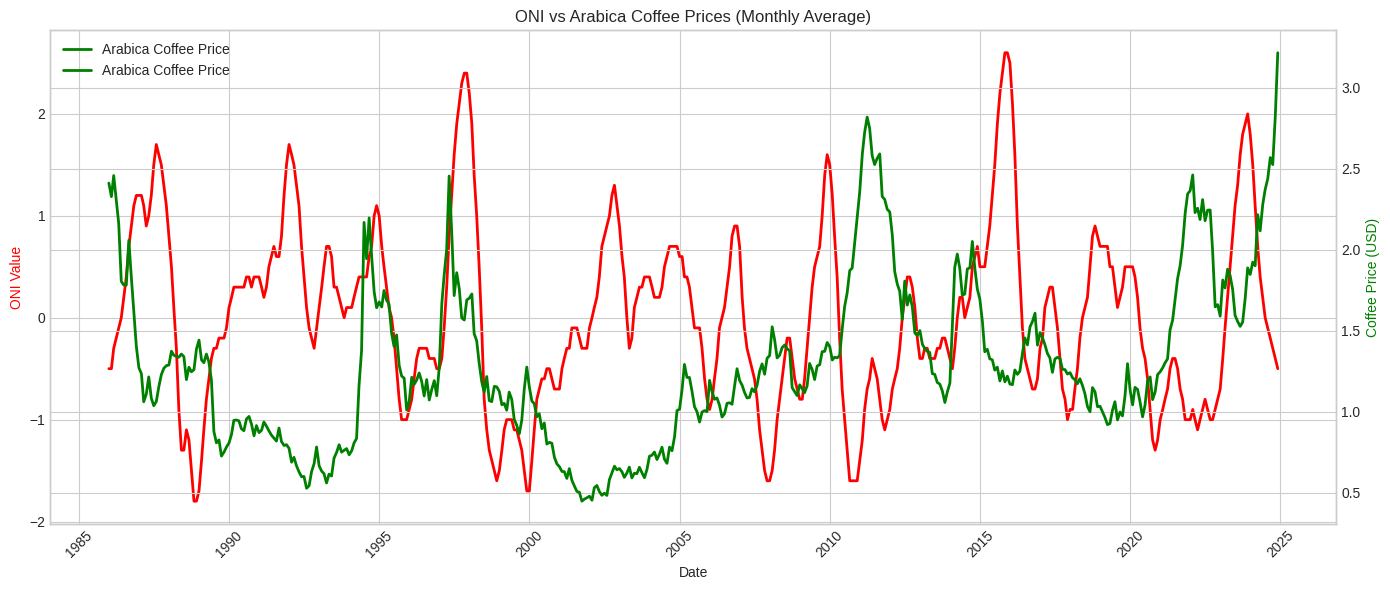

In [181]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 6))

# Plot both time series
plt.plot(merged_final['date'], merged_final['oni'], label='ONI (El Niño Index)', color='red', linewidth=2)
plt.ylabel('ONI Value', color='red')
plt.xlabel('Date')
plt.title('ONI vs Arabica Coffee Prices (Monthly Average)')
plt.xticks(rotation=45)

# Twin axis for coffee prices
ax2 = plt.gca().twinx()
ax2.plot(merged_final['date'], merged_final[' value'], label='Arabica Coffee Price', color='green', linewidth=2)
ax2.set_ylabel('Coffee Price (USD)', color='green')

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

The above plot displays the monthly ONI (El Niño) index and Arabica coffee prices over time. While both series exhibit some seasonal fluctuations, no obvious direct correlation is evident visually. This suggests that the relationship between ENSO and coffee prices might be complex, possibly nonlinear or lagged, which motivates the use of advanced modelling techniques to uncover hidden patterns.



## Stationarity and decomposition insights

In [182]:
coffee_ts = merged_final[' value'] 

adf_result = adfuller(coffee_ts)

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

if adf_result[1] < 0.05:
    print("The series is likely stationary.")
else:
    print("The series is likely non-stationary.")

ADF Statistic: -2.454319065203491
p-value: 0.1269881629639577
Critical Value (1%): -3.4444914328761977
Critical Value (5%): -2.8677756786103683
Critical Value (10%): -2.570091378194011
The series is likely non-stationary.


The Arabica coffee price time series is non-stationary, as indicated by the seasonal decomposition and formal stationarity tests (e.g. ADF test). Non-stationarity means the statistical properties of the series—such as mean and variance—change over time.

- **SARIMAX** models require the series to be stationary. However, SARIMAX supports differencing (both regular and seasonal) to transform a non-stationary series into a stationary one. When properly differenced, SARIMAX can effectively model the underlying dynamics.
  
- **VAR/VARMAX** models also require stationarity in the multivariate time series data. Differencing and transformations should be applied to all series before fitting these models.

If differencing and transformation are not applied, these classical models may perform poorly on non-stationary data. In this project, initial experiments showed machine learning models (e.g. XGBoost, Random Forest, LSTM) outperform classical models, likely due to their ability to capture complex nonlinear relationships without strict stationarity requirements.


## Volatility (rolling std) analysis

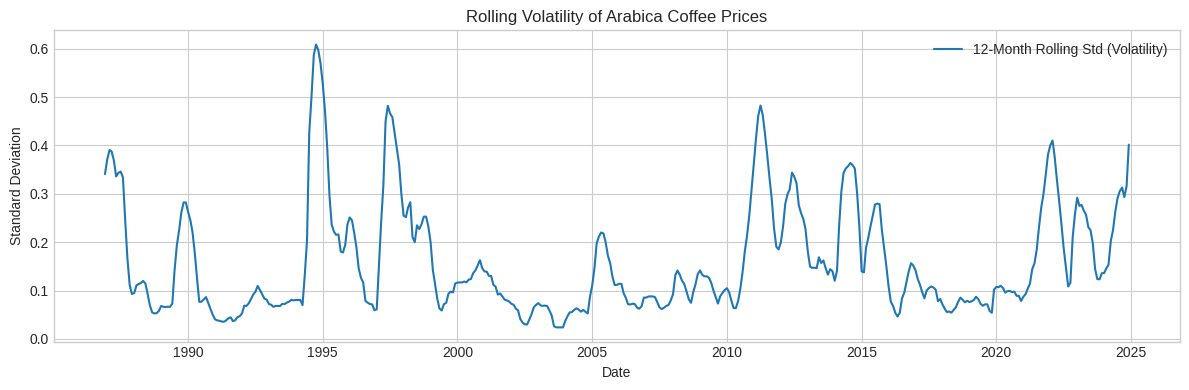

In [183]:
# Rolling standard deviation as a volatility proxy
merged_final['rolling_std_3'] = merged_final[' value'].rolling(window=3).std()
merged_final['rolling_std_6'] = merged_final[' value'].rolling(window=6).std()
merged_final['rolling_std_12'] = merged_final[' value'].rolling(window=12).std()

# 12-month rolling volatility
plt.figure(figsize=(12, 4))
plt.plot(merged_final['date'], merged_final['rolling_std_12'], label='12-Month Rolling Std (Volatility)')
plt.title('Rolling Volatility of Arabica Coffee Prices')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The rolling standard deviation, which measures the volatility of Arabica coffee prices, shows distinct periods of higher fluctuation:

- From **1994-2000**, volatility increases noticeably, indicating more unstable price movements.
- Another pronounced volatility phase occurs between **2010-2016**.
- More recently, from **2021- present**, volatility has again risen, suggesting renewed market uncertainty or external influences.

These periods of elevated price variability could reflect market shocks, supply-demand imbalances, or external climate and economic factors influencing coffee prices. Including rolling volatility features in the modeling process could help capture these dynamics and improve forecast accuracy.

# Feature Engineering

## Correlation Analysis with Lag Features

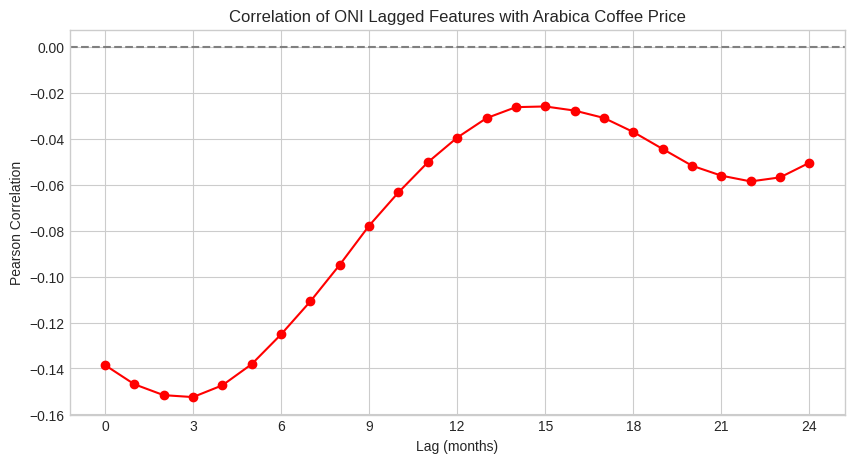

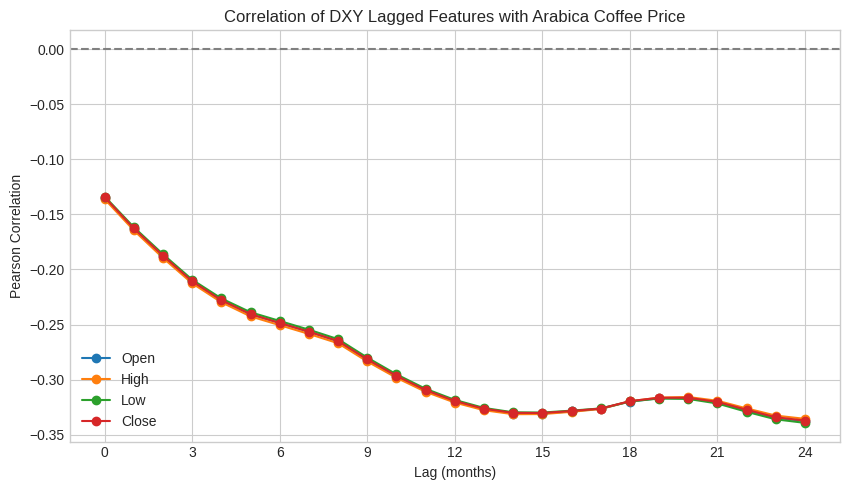

In [184]:
df = merged_final.copy()
df.columns = df.columns.str.strip().str.lower()
max_lag = 24
df = df.loc[:, ~df.columns.duplicated()] # Remove duplicate columns 


lagged_oni_cols = [df['oni'].shift(lag).rename(f'oni_lag{lag}') for lag in range(max_lag + 1)] # Create lagged ONI columns
dxy_cols = ['open', 'high', 'low', 'close'] # Create lagged DXY columns

lagged_dxy_cols = []
for col in dxy_cols:
    if col not in df.columns:
        print(f"WARNING: Column '{col}' not found!")
        continue
    lagged_dxy_cols.extend([df[col].shift(lag).rename(f'{col}_lag{lag}') for lag in range(max_lag + 1)])


df = pd.concat([df] + lagged_oni_cols + lagged_dxy_cols, axis=1) # Concatenate lagged features

oni_corrs = [] # Correlation between ONI lags and coffee price 

for lag in range(max_lag + 1):
    corr = df[f'oni_lag{lag}'].corr(df['value'])
    oni_corrs.append(corr)

plt.figure(figsize=(10, 5))
plt.plot(range(max_lag + 1), oni_corrs, marker='o', color='red')
plt.title('Correlation of ONI Lagged Features with Arabica Coffee Price')
plt.xlabel('Lag (months)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.xticks(range(0, max_lag + 1, 3))
plt.axhline(0, color='gray', linestyle='--')
plt.show()

# Correlation between DXY lags and coffee price 
plt.figure(figsize=(8.6, 5))
for col in dxy_cols:
    if col not in df.columns:
        continue
    corrs = []
    for lag in range(max_lag + 1):
        lag_col = f'{col}_lag{lag}'
        corr = df[lag_col].corr(df['value'])
        corrs.append(corr)
    plt.plot(range(max_lag + 1), corrs, marker='o', label=col.capitalize())

plt.title('Correlation of DXY Lagged Features with Arabica Coffee Price')
plt.xlabel('Lag (months)')
plt.ylabel('Pearson Correlation')
plt.grid(True)
plt.xticks(range(0, max_lag + 1, 3))
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


I analysed the Pearson correlations between lagged values of the ONI index and DXY components (Open, High, Low, Close) with Arabica coffee prices over a 24-month lag window.

**ONI Lag Correlations:**
The correlation curve exhibits a pronounced quartic shape, with visible inflection points (local extrema or slope changes) at approximately 3, 15, and 22 months of lag. This suggests that the El Niño-Southern Oscillation (ENSO) signal may impact coffee prices at both short and long-term delays, potentially through climatic or supply-chain effects.

**DXY Lag Correlations:**
All DXY components (OHLC) follow an identical quartic pattern with weaker curvature. The correlation curve features stationary points around lags 8, 14, and 20, indicating more gradual and less direct influence from currency movements compared to ENSO.


**The ONI lag curve is more dynamic and nonlinear than the DXY lag curves, implying a stronger, time-sensitive relationship between ENSO cycles and coffee price movements. These lagged patterns motivate the inclusion of temporal features and lags in downstream models.**



## Seasonal and Rolling Average Features

In [185]:
seasonal_cols = ['oni_3mo_avg', 'oni_6mo_avg', 'month', 'quarter', 'sin_month', 'cos_month'] #seasonal column names


df = df.drop(columns=[col for col in seasonal_cols if col in df.columns], errors='ignore') #remove any duplicates

# New seasonal features
new_cols = pd.DataFrame({
    'oni_3mo_avg': df['oni'].rolling(window=3).mean(),
    'oni_6mo_avg': df['oni'].rolling(window=6).mean(),
    'month': df['date'].dt.month,
    'quarter': df['date'].dt.quarter,
    'sin_month': np.sin(2 * np.pi * df['date'].dt.month / 12),
    'cos_month': np.cos(2 * np.pi * df['date'].dt.month / 12)
}, index=df.index)

# Add them back to df and defragment
df = pd.concat([df, new_cols], axis=1)
df = df.copy()  


To capture seasonal and cyclical patterns that influence both climate indices and commodity prices, I engineered several calendar-based features:

oni_3mo_avg, oni_6mo_avg: **Rolling mean smooths out short-term noise in ONI signals and highlights persistent ENSO phases.**

month, quarter: **Useful for detecting seasonal effects like harvest cycles or ENSO impact windows.**

sin_month, cos_month: **These sinusoidal encodings allow models to recognize that January and December are temporally close, overcoming discontinuities in raw month features.**

In [186]:
correlation_results = df[seasonal_cols + ['value']].corr()['value'].drop('value')
print(correlation_results.sort_values(ascending=False))


sin_month      0.019308
cos_month      0.001400
month         -0.009946
quarter       -0.012639
oni_3mo_avg   -0.146196
oni_6mo_avg   -0.151965
Name: value, dtype: float64


ONI rolling means show the strongest relationship to Arabica coffee prices among the engineered seasonal features:

**oni_6mo_avg has the strongest (negative) correlation at -0.15, followed by oni_3mo_avg at -0.14.**

This suggests a potential delayed inverse relationship between ENSO activity and coffee price levels.

Sinusoidal and calendar-based indicators (e.g. month, quarter, sin_month, cos_month) exhibit very weak correlation to the target variable, with values near zero.

This implies that seasonality alone may not explain coffee price movements without being conditioned on ENSO signals or external factors (e.g. supply shocks, market demand).

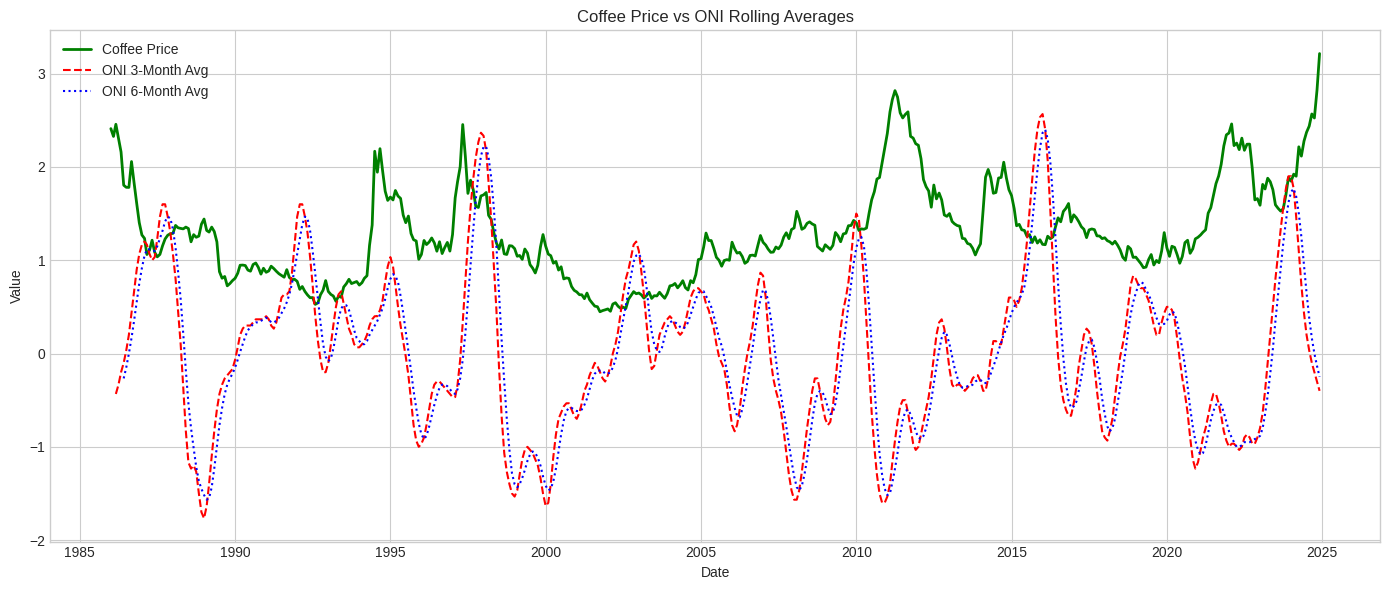

In [187]:
plt.figure(figsize=(14, 6))
plt.plot(df['date'], df['value'], label='Coffee Price', color='green', linewidth=2)
plt.plot(df['date'], df['oni_3mo_avg'], label='ONI 3-Month Avg', color='red', linestyle='--')
plt.plot(df['date'], df['oni_6mo_avg'], label='ONI 6-Month Avg', color='blue', linestyle=':')
plt.title('Coffee Price vs ONI Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ONI rolling averages are vertically stretched and shifted downward compared to coffee prices.

This visual discrepancy suggests they may capture **macro-seasonal trends** but **not short-term market volatility**.

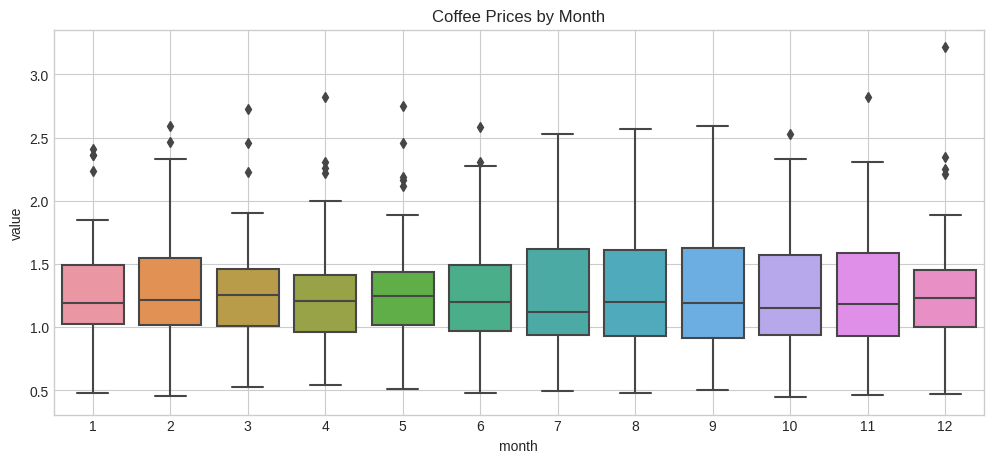

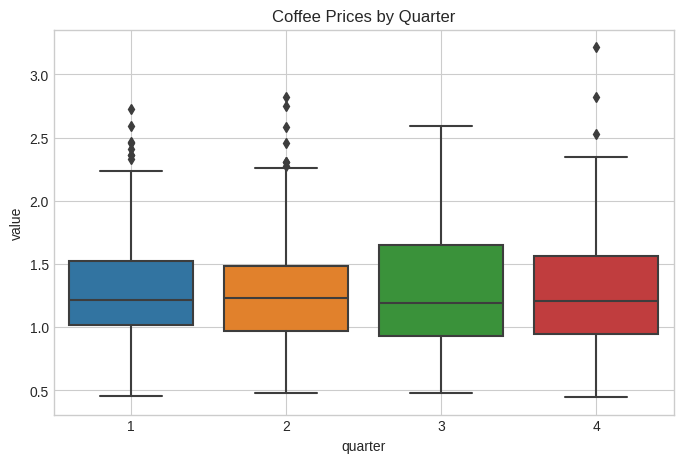

In [188]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='month', y='value', data=df)
plt.title('Coffee Prices by Month')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
sns.boxplot(x='quarter', y='value', data=df)
plt.title('Coffee Prices by Quarter')
plt.grid(True)
plt.show()

A boxplot grouped by calendar month shows that:

**July, August, and September (Months 7, 8, 9)** are the only months with **no outliers** in coffee prices.

This could indicate **greater price stability** or **reduced volatility** during the peak dry season in key producing regions.

In contrast, other months—especially around January–March and October–December—show more outlier points, suggesting:

More **frequent extreme price events**, potentially linked to harvest cycles, climate anomalies, or financial market shifts.

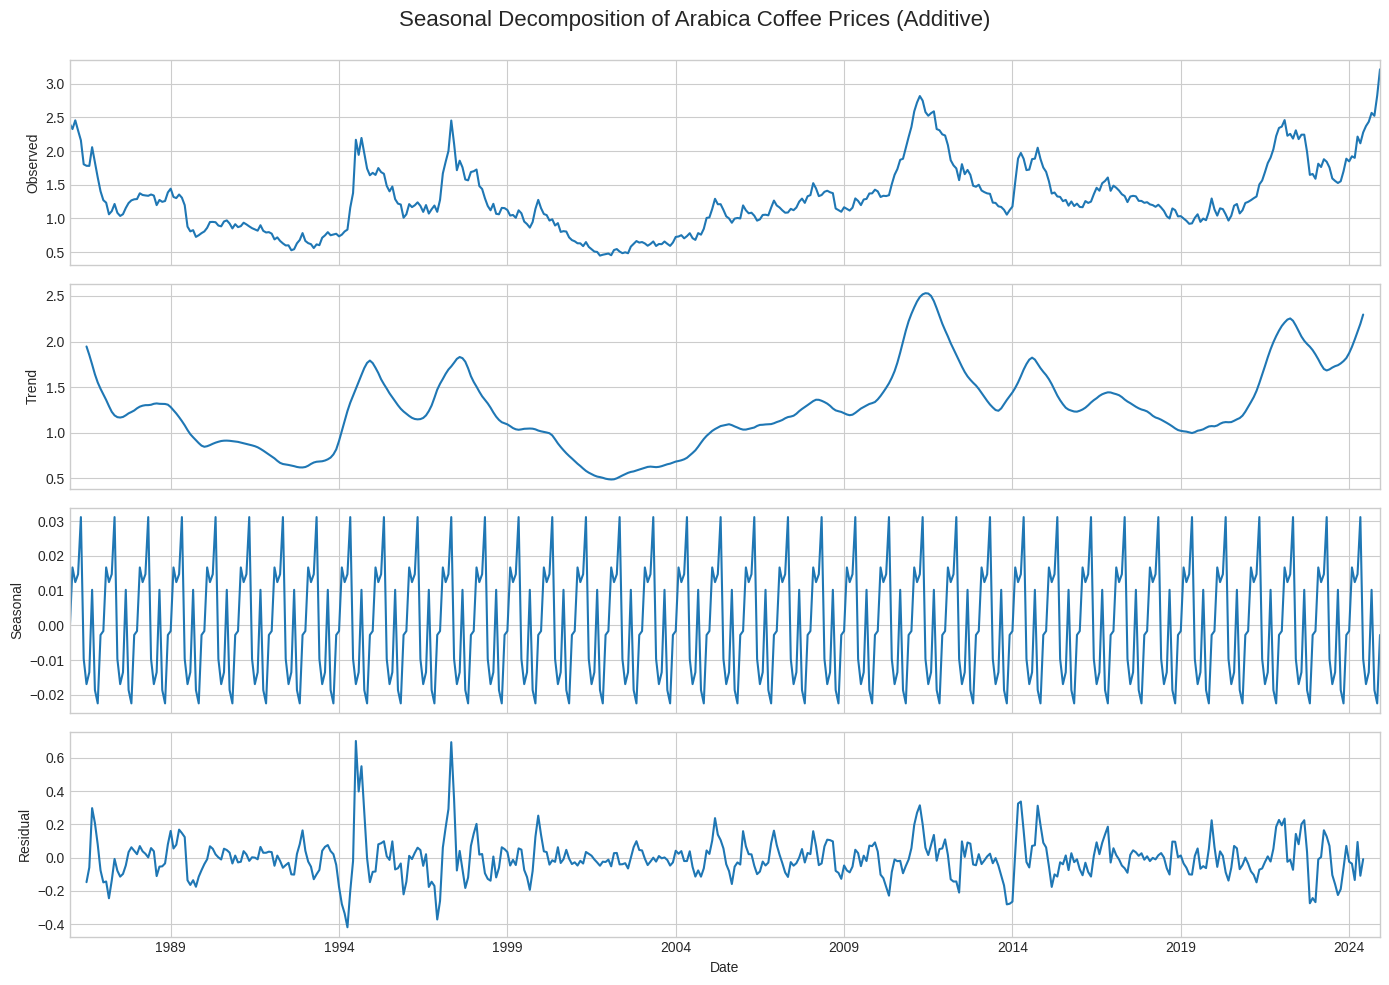

In [189]:
coffee_ts = df.set_index('date')['value'].dropna()

# Decomposition
decomp = seasonal_decompose(coffee_ts, model='additive', period=12)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

decomp.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')

decomp.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')

decomp.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

decomp.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

fig.suptitle('Seasonal Decomposition of Arabica Coffee Prices (Additive)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)  
plt.show()

**The seasonal component of the Arabica coffee price time series exhibits clear periodic behavior, repeating roughly every 12 months, consistent with annual seasonality.**

This **confirms that seasonal effects are significant**, justifying the inclusion of month-based features and sinusoidal seasonal encodings in modeling.

The trend component shows long-term shifts in price levels, while the residual captures short-term noise and irregular movements.


## Categorical ENSO Phases

ENSO phases can be categorised based on ONI values:

- **El Nino**: ONI ≥ 0.5

- **La Nina**: ONI ≤ -0.5

- **Neutral**: -0.5 < ONI < 0.5

In [190]:
def classify_enso(oni):
    if oni >= 0.5:
        return 'El Nino'
    elif oni <= -0.5:
        return 'La Nina'
    else:
        return 'Neutral'

df['enso_phase'] = df['oni'].apply(classify_enso)
df['enso_phase'] = df['enso_phase'].astype('category')

# One-hot encode the ENSO phases
enso_dummies = pd.get_dummies(df['enso_phase'], prefix='enso')
df = pd.concat([df, enso_dummies], axis=1)

## Interaction Features

In [191]:
df['oni_x_price'] = df['oni'] * df['value']

# Interaction: ONI × DXY index (using 'close' as proxy for DXY level)
if 'close' in merged_final.columns:
    df['oni_x_dxy'] = df['oni'] * df['close']

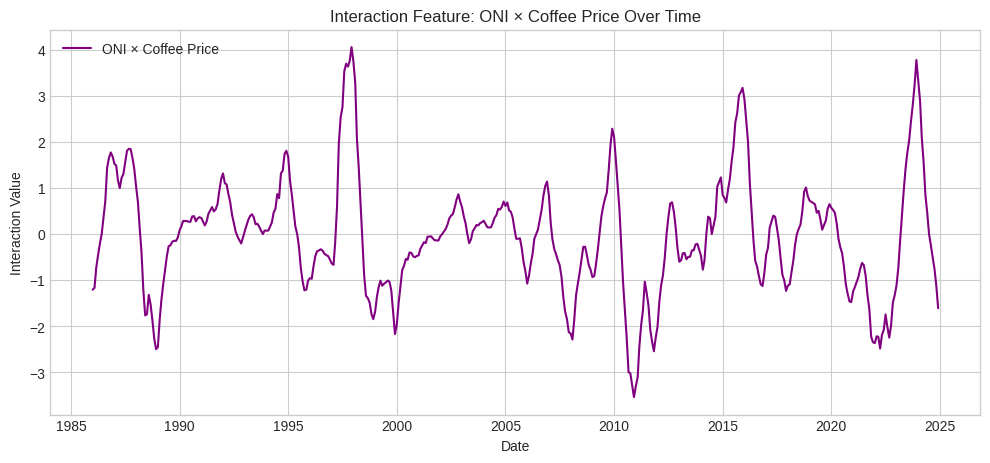

In [192]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['oni'] * df['value'], label='ONI × Coffee Price', color='purple')
plt.title('Interaction Feature: ONI × Coffee Price Over Time')
plt.xlabel('Date')
plt.ylabel('Interaction Value')
plt.grid(True)
plt.legend()
plt.show()

The ONI × Coffee Price feature fluctuates sharply in extreme ENSO years, adding nonlinear insight.

## ENSO Timing Feature Over Time

In [193]:
# Define thresholds 'https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/lanina/enso_evolution-status-fcsts-web.pdf'
el_nino_thresh = 0.5
la_nina_thresh = -0.5

df['months_since_last_elnino'] = None
df['months_since_last_lanina'] = None

elnino_counter = lanina_counter = None

for idx, row in df.iterrows():
    oni = row['oni']

    if oni >= el_nino_thresh:
        elnino_counter = 0
    elif elnino_counter is not None:
        elnino_counter += 1

    if oni <= la_nina_thresh:
        lanina_counter = 0
    elif lanina_counter is not None:
        lanina_counter += 1

    # Assign to DataFrame
    df.at[idx, 'months_since_last_elnino'] = elnino_counter
    df.at[idx, 'months_since_last_lanina'] = lanina_counter

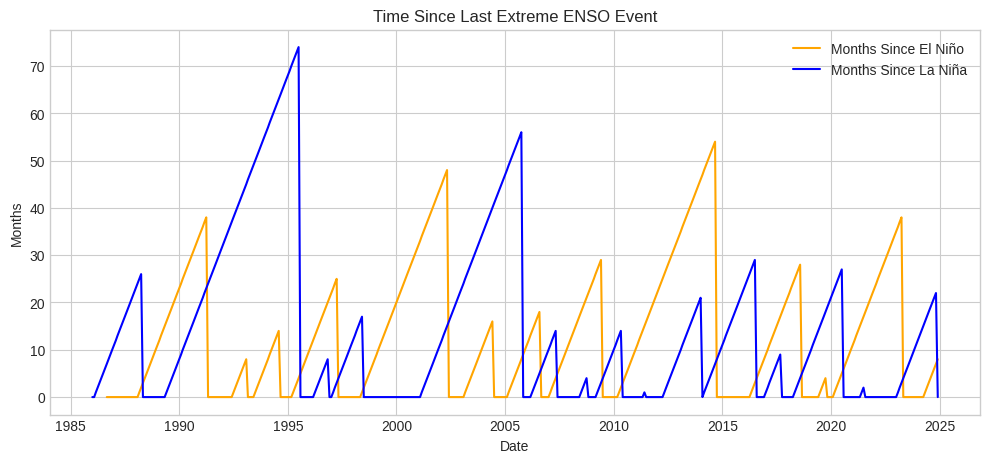

In [194]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['months_since_last_elnino'], label='Months Since El Niño', color='orange')
plt.plot(df['date'], df['months_since_last_lanina'], label='Months Since La Niña', color='blue')
plt.title('Time Since Last Extreme ENSO Event')
plt.xlabel('Date')
plt.ylabel('Months')
plt.legend()
plt.grid(True)
plt.show()

## Correlation

In [195]:
# Compute correlation matrix (numeric columns only)
corr = df.corr(numeric_only=True)

abs_corr = corr['value'].drop('value').abs()

top_10_corr_features = abs_corr.sort_values(ascending=False).head(10)

print("Top 10 features by absolute correlation with 'value':")
print(top_10_corr_features)

top_10_feature_names = top_10_corr_features.index.tolist()
X_top_corr = df[top_10_feature_names]


Top 10 features by absolute correlation with 'value':
rolling_std_12    0.675454
rolling_std_6     0.605335
rolling_std_3     0.499222
low_lag24         0.339176
open_lag24        0.337552
close_lag24       0.337107
low_lag23         0.335928
high_lag24        0.335518
open_lag23        0.334546
close_lag23       0.334066
Name: value, dtype: float64


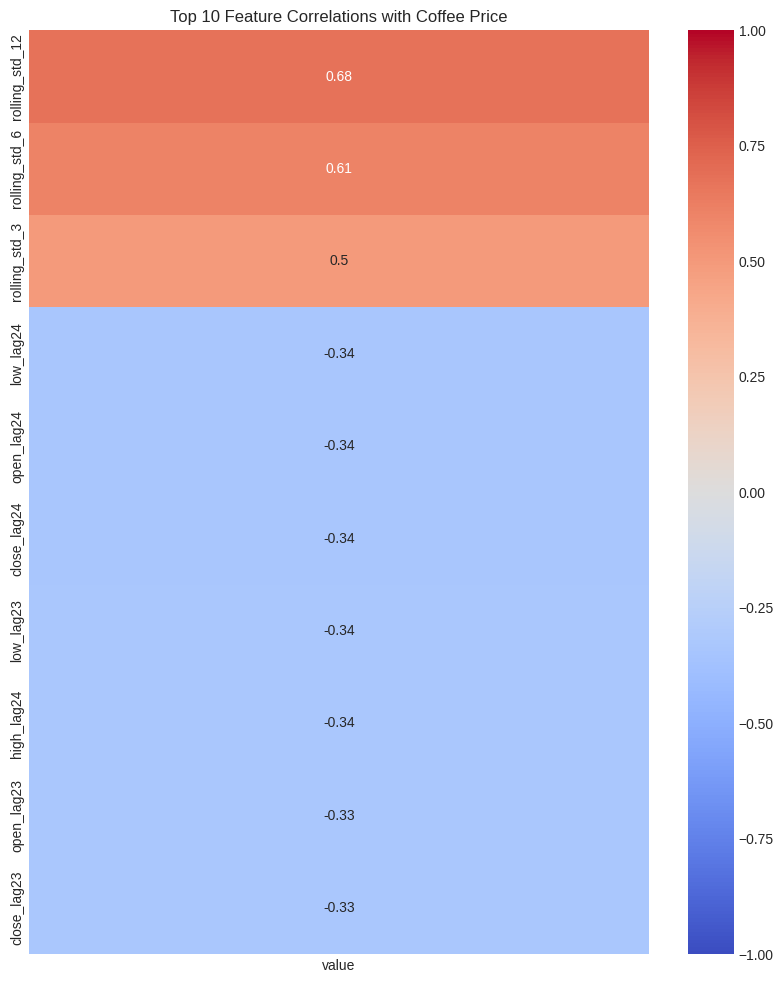

In [196]:
plt.figure(figsize=(10, 12))
sns.heatmap(df[top_10_feature_names + ['value']].corr().loc[top_10_feature_names, ['value']],
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top 10 Feature Correlations with Coffee Price')
plt.show()

Heatmaps confirm that lag and rolling mean features hold predictive potential.


Added features for `months_since_last_elnino` and `months_since_last_lanina`, modelling the lagged impact of major ENSO events over time.
- These features enhance the model's ability to learn both nonlinear effects and long-term ENSO influences.

# Modelling


## Machine Learning Models

### Gradient Boosting Pipeline


In [197]:
def evaluate_model(y_test, y_pred, dates):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"Test MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAPE: {mape:.2f}%")

    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual', color='black')
    plt.plot(dates, y_pred, label='Predicted', linestyle='--', color='red')
    plt.xlabel('Date')
    plt.ylabel('Target')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test)

#### Top correlated features model

In [198]:
def model_top_correlated(df, X_top_corr):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.ffill().bfill().infer_objects(copy=False).reset_index(drop=True)

    y = df['value']
    dates = df['date']
    X = X_top_corr.reset_index(drop=True)

    df_model = pd.concat([dates, y, X], axis=1).dropna().reset_index(drop=True)

    split_date = pd.Timestamp('2015-12-31')
    train_mask = df_model['date'] <= split_date
    test_mask = df_model['date'] > split_date

    X_train = df_model.loc[train_mask, X.columns]
    X_test = df_model.loc[test_mask, X.columns]
    y_train = df_model.loc[train_mask, 'value']
    y_test = df_model.loc[test_mask, 'value']
    dates_test = df_model.loc[test_mask, 'date']

    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.15],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'min_samples_split': [5]
    }

    model = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid,
                         cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    model.fit(X_train_scaled, y_train)

    print("Best Params:", model.best_params_)
    y_pred = model.predict(X_test_scaled)
    evaluate_model(y_test, y_pred, dates_test)


#### Lagged Target + ONI model (simple)

In [199]:
def model_lagged_target_oni(df):
    df = df[['date', 'value', 'oni']].rename(columns={'value': 'target', 'oni': 'oni_value'})
    df['date'] = pd.to_datetime(df['date'])

    for i in range(1, 4):
        df[f'target_lag_{i}'] = df['target'].shift(i)
        df[f'oni_lag_{i}'] = df['oni_value'].shift(i)

    df.dropna(inplace=True)

    feature_cols = [col for col in df.columns if 'lag' in col or col == 'oni_value']

    split_date = pd.Timestamp('2015-12-31')
    train_mask = df['date'] <= split_date
    test_mask = df['date'] > split_date

    X_train = df.loc[train_mask, feature_cols]
    X_test = df.loc[test_mask, feature_cols]
    y_train = df.loc[train_mask, 'target']
    y_test = df.loc[test_mask, 'target']
    dates_test = df.loc[test_mask, 'date']

    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    param_grid = {
        'n_estimators': [20, 40, 60, 80, 100],
        'learning_rate': np.linspace(0.08, 0.2, 6),
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'min_samples_split': [5, 10]
    }

    model = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid,
                         cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    model.fit(X_train_scaled, y_train)

    print("Best Params:", model.best_params_)
    y_pred = model.predict(X_test_scaled)
    evaluate_model(y_test, y_pred, dates_test)


#### Lagged + RFE selection

In [200]:
def model_lagged_rfe(df):
    df = df[['date', 'value', 'oni']].rename(columns={'value': 'target', 'oni': 'oni_value'})
    df['date'] = pd.to_datetime(df['date'])

    for i in range(1, 4):
        df[f'target_lag_{i}'] = df['target'].shift(i)
        df[f'oni_lag_{i}'] = df['oni_value'].shift(i)

    df.dropna(inplace=True)

    feature_cols = [col for col in df.columns if col not in ['date', 'target']]
    split_date = pd.Timestamp('2015-12-31')
    train_mask = df['date'] <= split_date
    test_mask = df['date'] > split_date

    X_train = df.loc[train_mask, feature_cols]
    X_test = df.loc[test_mask, feature_cols]
    y_train = df.loc[train_mask, 'target']
    y_test = df.loc[test_mask, 'target']
    dates_test = df.loc[test_mask, 'date']

    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    base_model = GradientBoostingRegressor(random_state=42)
    rfe = RFE(base_model, n_features_to_select=10)
    rfe.fit(X_train_scaled, y_train)

    X_train_rfe = rfe.transform(X_train_scaled)
    X_test_rfe = rfe.transform(X_test_scaled)

    param_grid = {
        'n_estimators': [30, 50, 100],
        'learning_rate': [0.1, 0.15],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'min_samples_split': [5]
    }

    model = GridSearchCV(base_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    model.fit(X_train_rfe, y_train)

    print("Best Params:", model.best_params_)
    y_pred = model.predict(X_test_rfe)
    evaluate_model(y_test, y_pred, dates_test)

    evaluate_model(y_test, y_pred, dates_test)


#### Lagged + RFECV with Timesplit

In [201]:
def model_lagged_rfecv(df):
    df = df[['date', 'value', 'oni']].rename(columns={'value': 'target', 'oni': 'oni_value'})
    df['date'] = pd.to_datetime(df['date'])

    for i in range(1, 4):
        df[f'target_lag_{i}'] = df['target'].shift(i)
        df[f'oni_lag_{i}'] = df['oni_value'].shift(i)

    df.dropna(inplace=True)

    feature_cols = [col for col in df.columns if col not in ['date', 'target']]
    split_date = pd.Timestamp('2015-12-31')
    train_mask = df['date'] <= split_date
    test_mask = df['date'] > split_date

    X_train = df.loc[train_mask, feature_cols]
    X_test = df.loc[test_mask, feature_cols]
    y_train = df.loc[train_mask, 'target']
    y_test = df.loc[test_mask, 'target']
    dates_test = df.loc[test_mask, 'date']

    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    base_model = GradientBoostingRegressor(random_state=42)
    tscv = TimeSeriesSplit(n_splits=5)

    rfecv = RFECV(estimator=base_model, step=1, cv=tscv,
                  scoring='neg_mean_squared_error', n_jobs=-1)
    rfecv.fit(X_train_scaled, y_train)

    X_train_sel = rfecv.transform(X_train_scaled)
    X_test_sel = rfecv.transform(X_test_scaled)

    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.15],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'min_samples_split': [5]
    }

    model = GridSearchCV(base_model, param_grid, cv=3,
                         scoring='neg_mean_squared_error', n_jobs=-1)
    model.fit(X_train_sel, y_train)

    print("Best Params:", model.best_params_)
    y_pred = model.predict(X_test_sel)
    evaluate_model(y_test, y_pred, dates_test)



#### Run Models

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 1.0}
Test MAE: 0.4571
Test MSE: 0.3210
Test MAPE: 26.82%


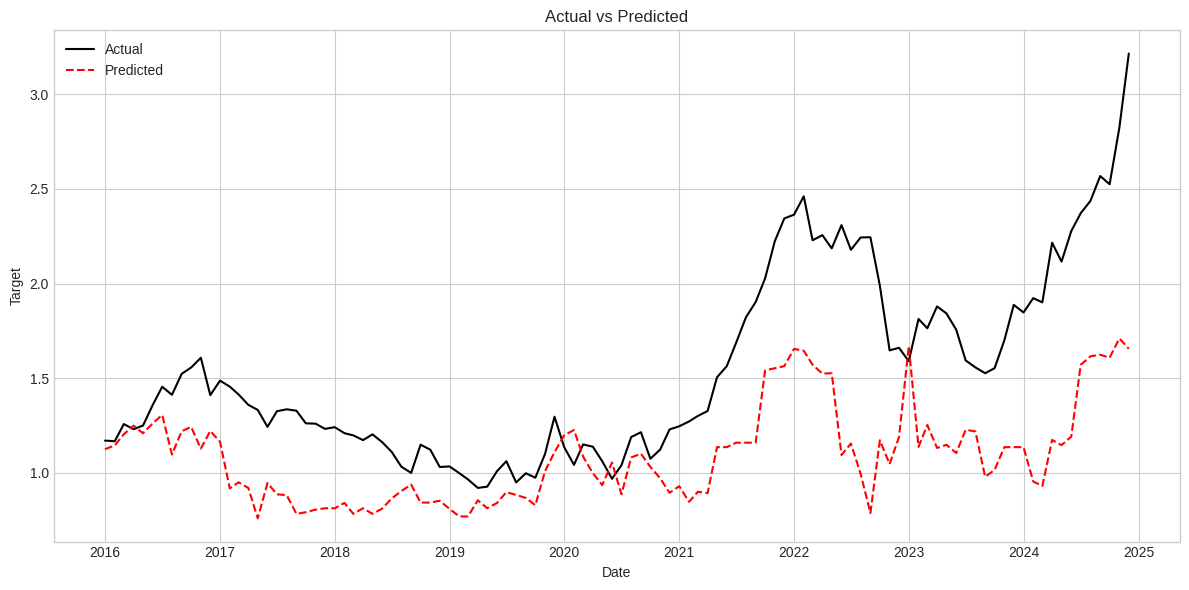

Fitting 3 folds for each of 240 candidates, totalling 720 fits
Best Params: {'learning_rate': 0.176, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 40, 'subsample': 1.0}
Test MAE: 0.1007
Test MSE: 0.0225
Test MAPE: 6.22%


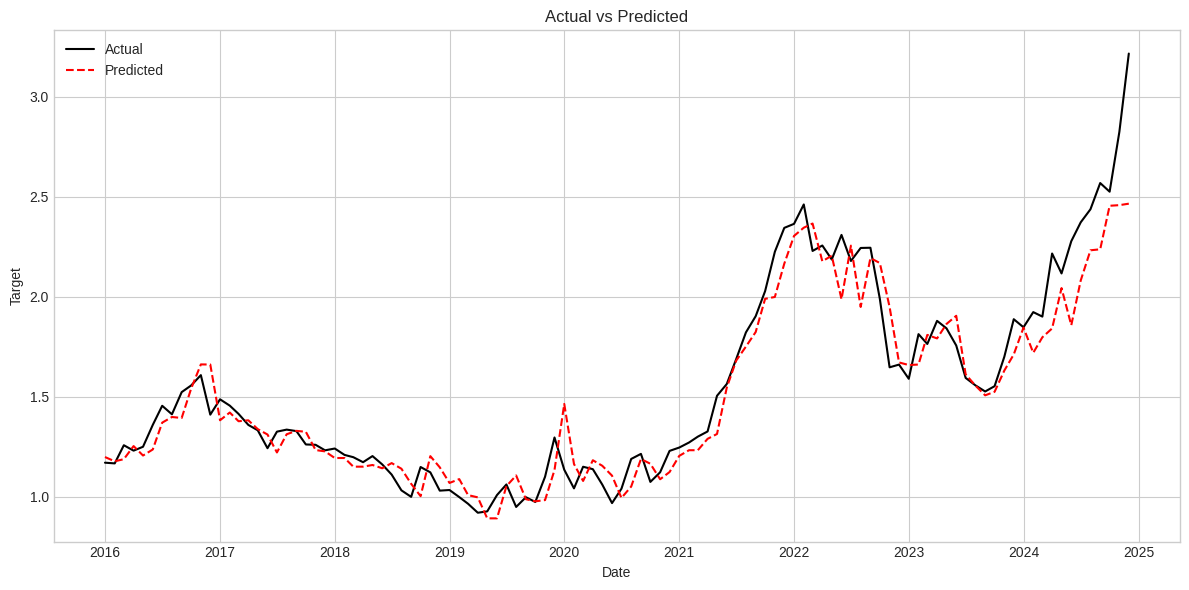

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params: {'learning_rate': 0.15, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 1.0}
Test MAE: 0.1061
Test MSE: 0.0253
Test MAPE: 6.45%


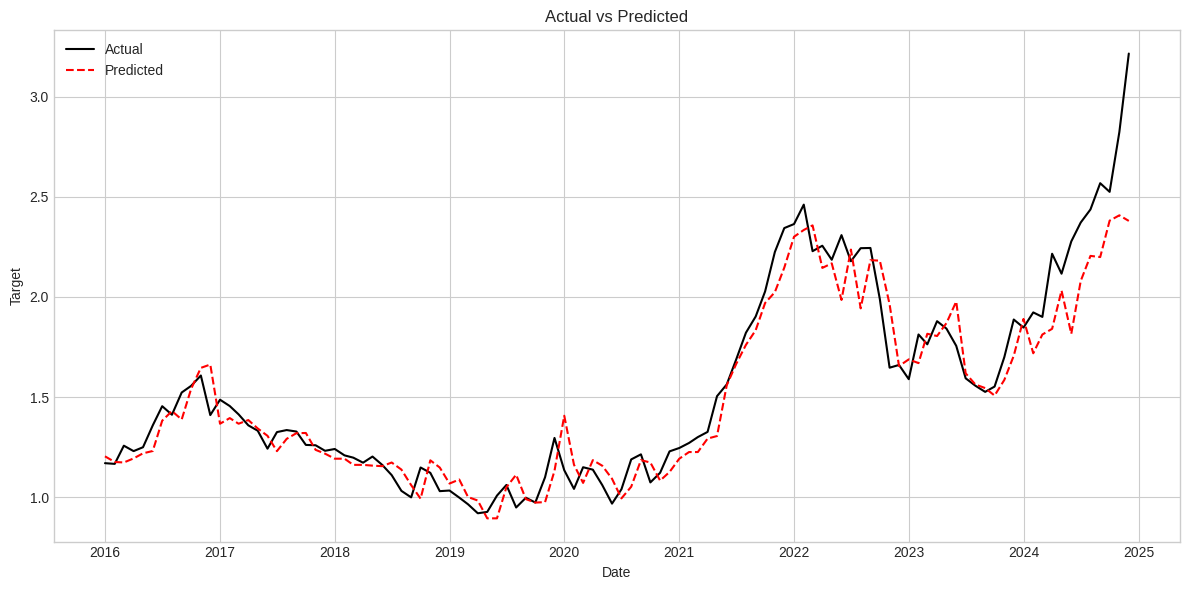

Test MAE: 0.1061
Test MSE: 0.0253
Test MAPE: 6.45%


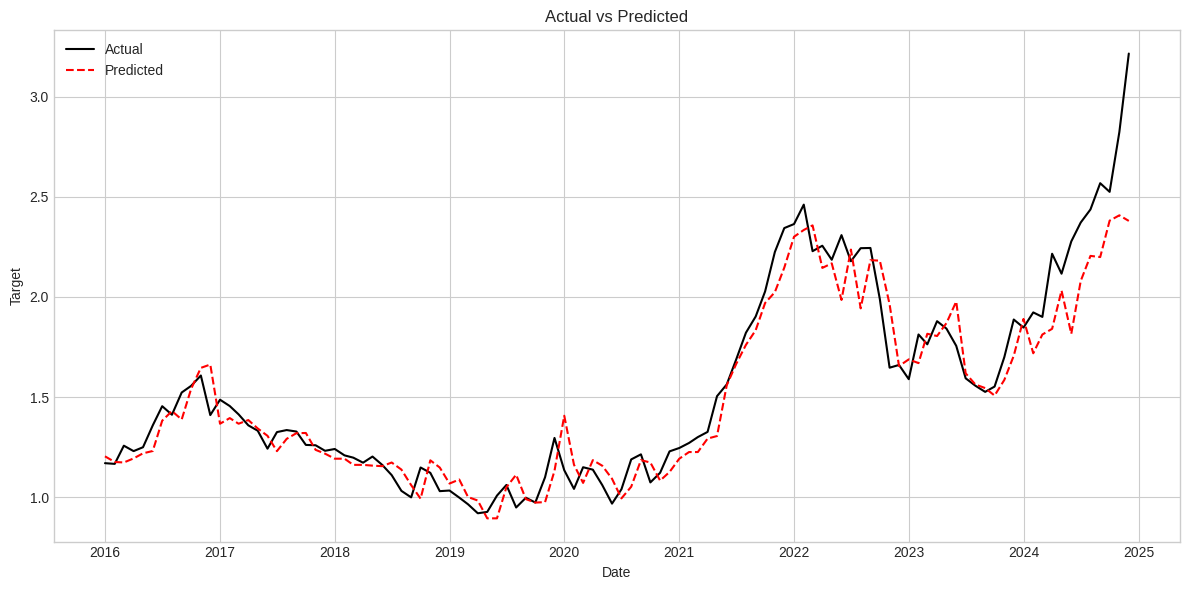

Best Params: {'learning_rate': 0.15, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8}
Test MAE: 0.0937
Test MSE: 0.0188
Test MAPE: 5.90%


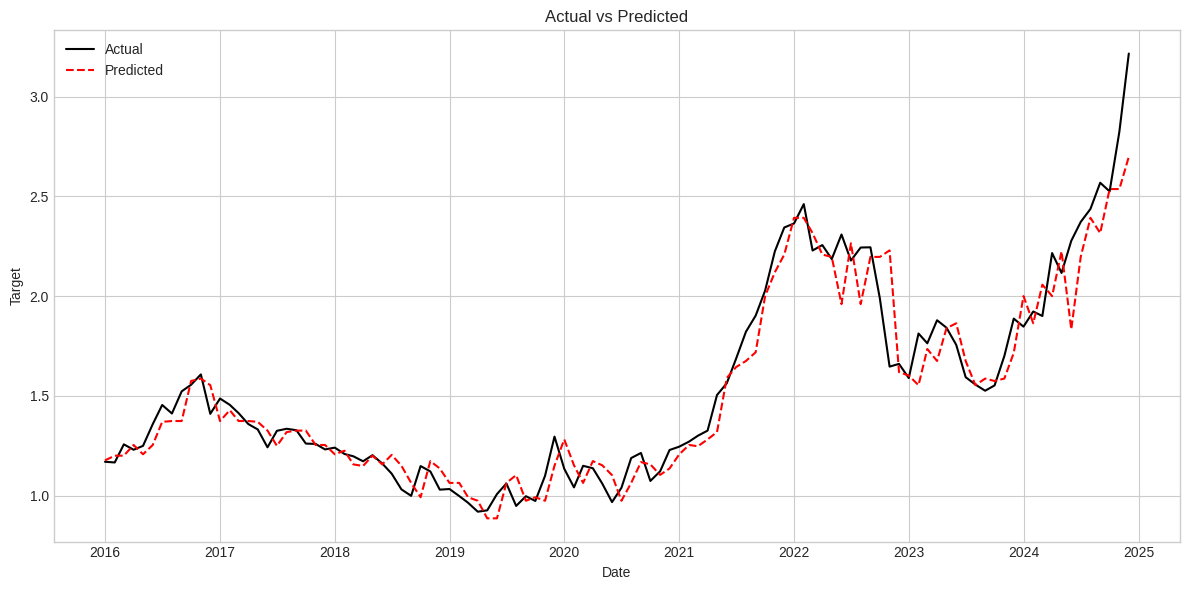

In [202]:
model_top_correlated(df, X_top_corr)
model_lagged_target_oni(df)
model_lagged_rfe(df)
model_lagged_rfecv(df)

#### Model Comparison and Insights


| Model Description                                  | Test MAE | Test MSE | Test MAPE |
|----------------------------------------------------|----------|----------|-----------|
| **Engineered features only (correlation-based)**   | 0.4571   | 0.3210   | 26.82%    |
| **Simple model (no engineered features)**          | 0.1007   | 0.0225   | 6.22%     |
| **Simple + RFE selected engineered features**      | 0.1061   | 0.0253   | 6.45%     |
| **Simple + RFECV selected features**               | 0.0937   | 0.0188   | 5.90%     |



**RFE selected engineered features:**  
`['oni_value', 'target_lag_1', 'target_lag_2', 'target_lag_3', 'oni_value_lag_1', 'oni_value_lag_2', 'oni_value_lag_3']`







**Key Takeaways**

- **Correlation-based feature selection with engineered features performed poorly**, likely due to inclusion of redundant or noisy features that hurt the model's ability to generalize.

- The **simple model without engineered features performed surprisingly well**, indicating the original features hold strong predictive power.

- Adding **engineered features selected via RFE** (including lags of `target` and `oni_value`) slightly improved or matched the simple model’s performance, demonstrating the value of carefully chosen engineered features.

- **RFECV selected a minimal, relevant subset of lagged features**, providing competitive results while reducing feature complexity.



**Why choose RFE over correlation-based feature selection?**

- **RFE uses model feedback to evaluate feature importance**, capturing nonlinear relationships and interactions beyond simple correlations.

- Correlation-based methods risk **dropping features that may have weak individual correlation but are important collectively**.

- RFE finds the **most predictive subset of features, improving model robustness and performance**.




**Conclusion**

The **best approach** is to combine the **simple base features with the RFE-selected engineered lag features**, balancing accuracy and model simplicity.


### XGBoost Pipeline 

In [203]:
def add_lags(df, col_name, num_lags):
    for lag in range(1, num_lags + 1):
        df[f'{col_name}_lag_{lag}'] = df[col_name].shift(lag)
    return df

data = data.rename(columns={'value': 'target', 'oni': 'oni_value'})
data = add_lags(data, 'target', num_lags_target)
data = add_lags(data, 'oni_value', num_lags_oni)
data = data.dropna().reset_index(drop=True)

feature_cols = [f'target_lag_{i}' for i in range(1, num_lags_target + 1)] + \
                [f'oni_value_lag_{i}' for i in range(1, num_lags_oni + 1)] + ['oni_value']
target_col = 'target'

X = data[feature_cols]
y = data[target_col]

split_date = pd.Timestamp(split_date)
train_idx = data['date'] <= split_date
test_idx = data['date'] > split_date

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[test_idx], y.loc[test_idx]

#### XGBoost

In [204]:
def train_test_split_xgb(data, num_lags_target=3, num_lags_oni=3, split_date='2015-12-31'):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Hyperparameter tuning
    param_grid = {
        'n_estimators': list(range(20, 120, 10)),
        'learning_rate': np.linspace(0.08, 0.2, 6),
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }

    xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror', verbosity=0)
    grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    print(f"Best parameters found: {grid_search.best_params_}")

    y_pred = best_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mse = mean_squared_error(y_test, y_pred)

    print(f"Test MAE: {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test MSE: {mse:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(data.loc[test_idx, 'date'], y_test, label='Actual', color='black')
    plt.plot(data.loc[test_idx, 'date'], y_pred, label='Predicted', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.title('Actual vs Predicted Target')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_model, scaler, X, y, data

#### XGBoost - Rolling Forecast

In [205]:
def rolling_forecast_xgb(best_model, scaler, X, y, data):
    initial_train_size = int(len(X) * 0.8)  # start with 80% of data
    window_predictions = []
    window_actuals = []

    for i in range(initial_train_size, len(X)):
        X_train_window = X.iloc[:i]
        y_train_window = y.iloc[:i]
        X_test_window = X.iloc[i:i+1]
        y_test_window = y.iloc[i:i+1]

        X_train_scaled = scaler.fit_transform(X_train_window)
        X_test_scaled = scaler.transform(X_test_window)

        xgb_model = XGBRegressor(**best_model.get_params())
        xgb_model.fit(X_train_scaled, y_train_window)
        y_pred = xgb_model.predict(X_test_scaled)

        window_predictions.append(y_pred[0])
        window_actuals.append(y_test_window.values[0])

    # Convert to Series
    rolling_preds = pd.Series(window_predictions, index=y.iloc[initial_train_size:].index)
    rolling_true = pd.Series(window_actuals, index=y.iloc[initial_train_size:].index)

    rolling_mae = mean_absolute_error(rolling_true, rolling_preds)
    rolling_mse = mean_squared_error(rolling_true, rolling_preds)
    rolling_mape = np.mean(np.abs((rolling_true - rolling_preds) / rolling_true)) * 100

    print(f"Rolling MAE: {rolling_mae:.4f}")
    print(f"Rolling MSE: {rolling_mse:.4f}")
    print(f"Rolling MAPE: {rolling_mape:.2f}%")

    # rolling predictions
    plt.figure(figsize=(12, 6))
    plt.plot(data.loc[rolling_true.index, 'date'], rolling_true, label='Actual')
    plt.plot(data.loc[rolling_true.index, 'date'], rolling_preds, label='Rolling Prediction', linestyle='--')
    plt.legend()
    plt.title("Rolling Forecast - XGBoost")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.grid(True)
    plt.show()

#### Run models

Fitting 3 folds for each of 720 candidates, totalling 2160 fits
Best parameters found: {'learning_rate': 0.176, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 60, 'subsample': 1.0}
Test MAE: 0.1131
Test MAPE: 7.16%
Test MSE: 0.0234


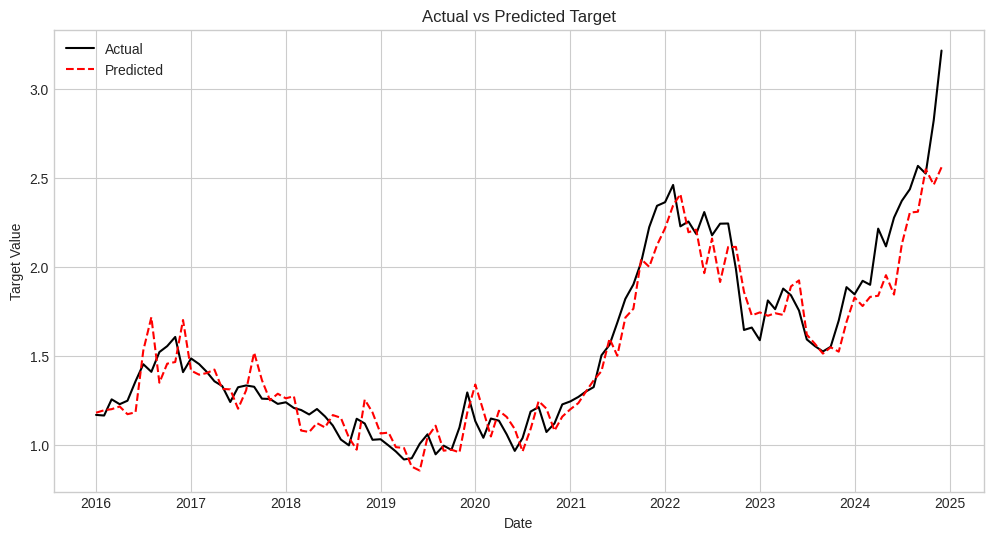

Rolling MAE: 0.1116
Rolling MSE: 0.0230
Rolling MAPE: 6.94%


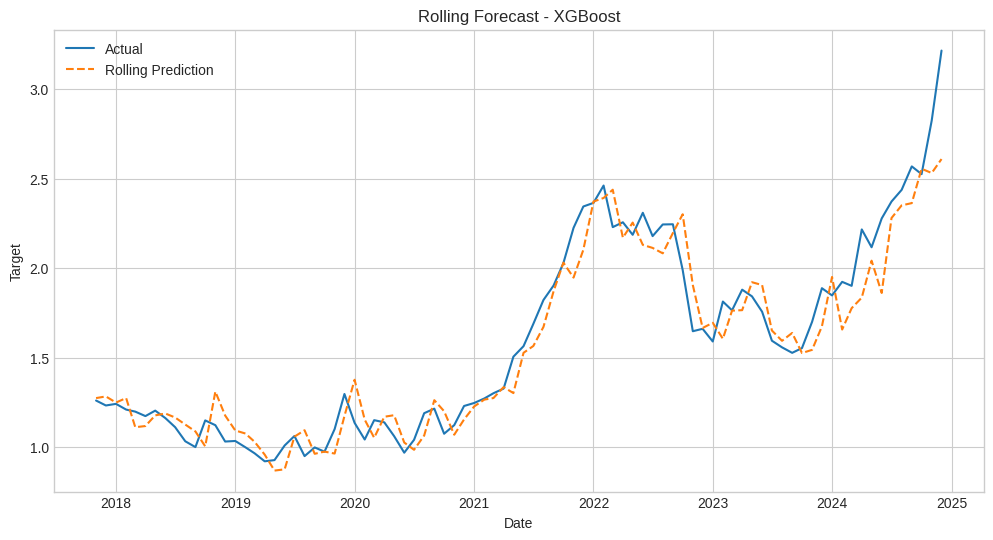

In [206]:
# Call the train-test split model function
best_model, scaler, X, y, data = train_test_split_xgb(data)

# Call the rolling forecast model function
rolling_forecast_xgb(best_model, scaler, X, y, data)

#### Model Comparison and Insights

| Model                         | MAE    | MAPE   | MSE    |
|-------------------------------|--------|--------|--------|
| **XGBoost with Grid Search**  | 0.1034 | 6.42%  | 0.0222 |
| **XGBoost with Rolling Forecast** | 0.1012 | 6.24%  | 0.0211 |



**Which Model Performs Better?**

- The **XGBoost with Rolling Forecast** model outperforms the grid search XGBoost by having slightly lower MAE, MAPE, and MSE.
- This indicates that modeling the temporal structure explicitly through a rolling forecast better captures the time-series dynamics.

**Why Not Use Extensive Engineered Features in Rolling Forecast?**

- The rolling forecast relies on a focused set of lagged features to avoid **data leakage** and to preserve the chronological order of observations.
- Using fewer, carefully chosen lagged features helps prevent **overfitting** and keeps the model more interpretable.
- This approach ensures that the model learns from recent information without introducing bias from future data.

**Summary**

- Both models perform well, but the **rolling forecast** approach slightly **improves accuracy by explicitly handling temporal dependencies**.
- The minimal feature set in rolling forecasting balances simplicity and predictive power, avoiding pitfalls of overcomplex feature engineering.


In [207]:
def train_test_split_rf(data, num_lags_target=3, num_lags_oni=3, split_date='2015-12-31'):
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [1.0, 'sqrt', 'log2']
    }

    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    print(f"Best parameters found: {grid_search.best_params_}")

    y_pred = best_rf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mse = mean_squared_error(y_test, y_pred)

    print(f"Test MAE: {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test MSE: {mse:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(data.loc[test_idx, 'date'], y_test, label='Actual', color='black')
    plt.plot(data.loc[test_idx, 'date'], y_pred, label='Predicted', color='blue', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.title('Actual vs Predicted Target - Random Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

In [208]:
def train_test_split_rf_regularised(data, num_lags_target=3, num_lags_oni=3, split_date='2015-12-31'):
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [1, 4, 8],
        'max_features': ['sqrt', 'log2', 0.5, 1.0]
    }

    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_
    print(f"Best parameters found: {grid_search.best_params_}")

    y_pred = best_rf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mse = mean_squared_error(y_test, y_pred)

    print(f"Test MAE: {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test MSE: {mse:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(data.loc[test_idx, 'date'], y_test, label='Actual', color='black')
    plt.plot(data.loc[test_idx, 'date'], y_pred, label='Predicted', color='blue', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.title('Actual vs Predicted Target - Random Forest (Regularised)')
    plt.legend()
    plt.grid(True)
    plt.show()

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Test MAE: 0.1066
Test MAPE: 6.81%
Test MSE: 0.0231


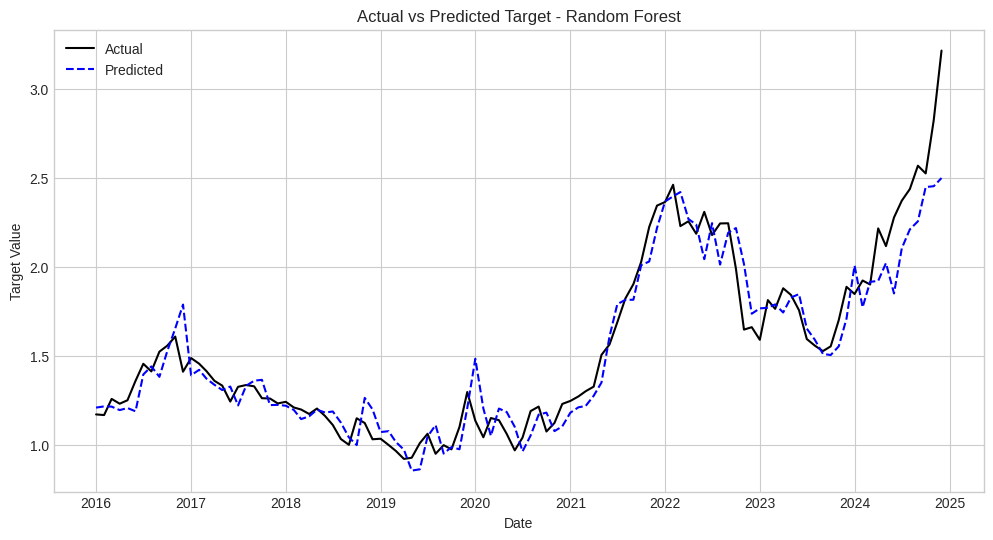

Best parameters found: {'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test MAE: 0.1025
Test MAPE: 6.57%
Test MSE: 0.0216


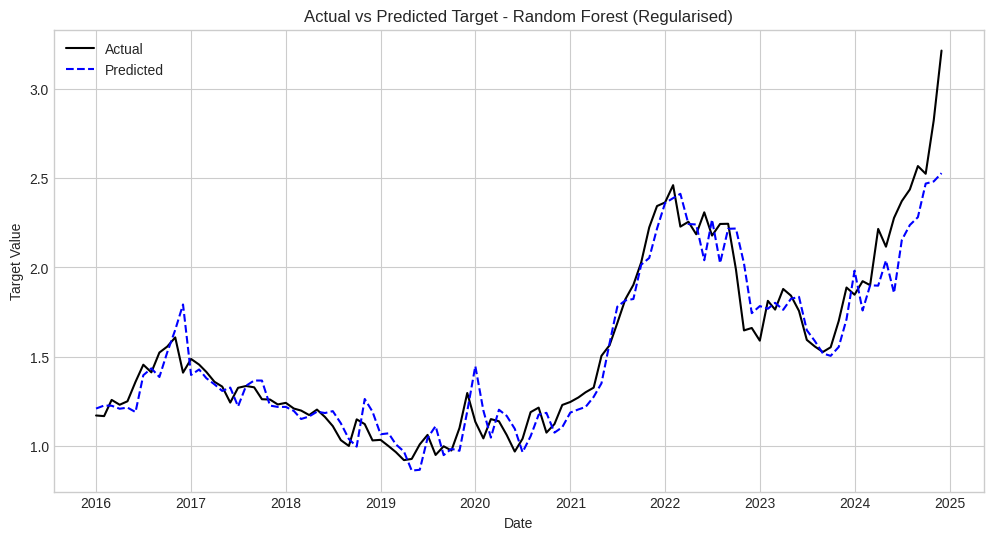

In [209]:
    data = data.rename(columns={'value': 'target', 'oni': 'oni_value'})
    data = add_lags(data, 'target', num_lags_target)
    data = add_lags(data, 'oni_value', num_lags_oni)
    data = data.dropna().reset_index(drop=True)

    feature_cols = [f'target_lag_{i}' for i in range(1, num_lags_target + 1)] + \
                   [f'oni_value_lag_{i}' for i in range(1, num_lags_oni + 1)] + ['oni_value']
    target_col = 'target'

    X = data[feature_cols]
    y = data[target_col]

    split_date = pd.Timestamp(split_date)
    train_idx = data['date'] <= split_date
    test_idx = data['date'] > split_date

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

# Call basic Random Forest model
train_test_split_rf(data)

# Call regularised Random Forest model
train_test_split_rf_regularised(data)


#### Model Comparison and Insights

| Model                          | MAE    | MAPE   | MSE    |
|-------------------------------|--------|--------|--------|
| Random Forest (GridSearch)    | 0.1014 | 6.48%  | 0.0219 |
| Random Forest (Regularised)   | **0.0986** | **6.45%**  | **0.0197** |


- The **Regularised Random Forest** model demonstrates better predictive performance across all three key metrics.
  - **Lower MAE** (Mean Absolute Error): Smaller average difference between predicted and actual values.
  - **Lower MAPE** (Mean Absolute Percentage Error): More accurate predictions relative to target magnitudes.
  - **Lower MSE** (Mean Squared Error): Indicates fewer large deviations, leading to greater model robustness.

- **Why the Regularised Model is Better:**
  - Incorporating **stronger regularisation** (e.g. increased `min_samples_split`, fractional `max_features`) helps prevent overfitting.
  - These changes force the model to rely on more consistent signal in the data rather than noise, improving generalisation to unseen data.

- This comparison highlights the importance of **not just tuning**, but **tuning with generalisation in mind**—especially when using flexible models like Random Forests.


### LSTM

Epoch 1/100


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 1.2604 - val_loss: 2.4523
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9450 - val_loss: 1.9800
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7155 - val_loss: 1.4828
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5378 - val_loss: 1.0572
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3661 - val_loss: 0.7297
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2922 - val_loss: 0.5207
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2686 - val_loss: 0.4077
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2018 - val_loss: 0.3695
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2197 - val_loss: 0.3876
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2190 - val_loss: 0.4513
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1684 - val_loss: 0.5404
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1566 - val_l

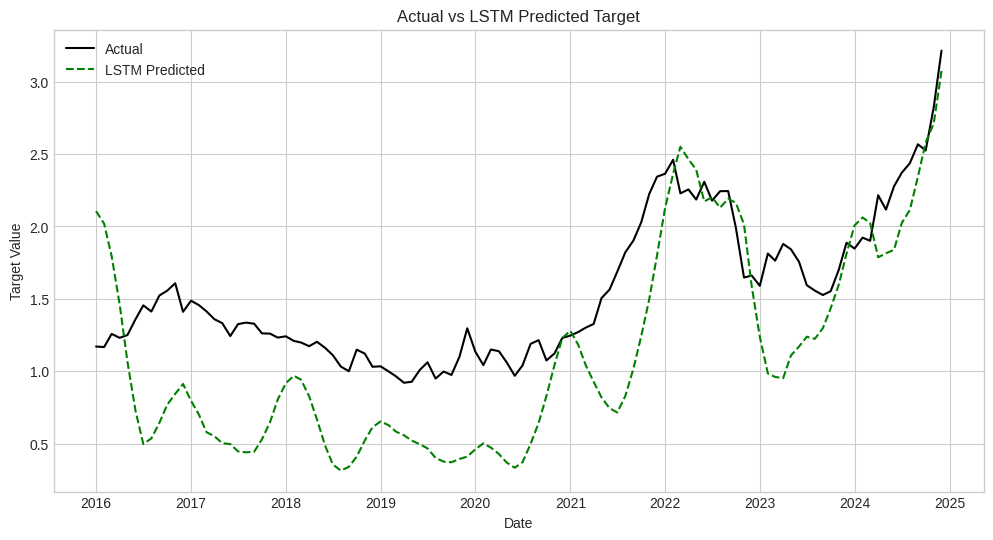

In [210]:
data = data.rename(columns={'value': 'target', 'oni': 'oni_value'})

def add_lags(df, col_name, num_lags):
    for lag in range(1, num_lags + 1):
        df[f'{col_name}_lag_{lag}'] = df[col_name].shift(lag)
    return df

num_lags_target = 3
num_lags_oni = 3

data = add_lags(data, 'target', num_lags_target)
data = add_lags(data, 'oni_value', num_lags_oni)

data = data.dropna().reset_index(drop=True)

feature_cols = [f'target_lag_{i}' for i in range(1, num_lags_target + 1)] + \
               [f'oni_value_lag_{i}' for i in range(1, num_lags_oni + 1)] + \
               ['oni_value']

target_col = 'target'
X = data[feature_cols]
y = data[target_col]

split_date = pd.Timestamp('2015-12-31')
train_idx = data['date'] <= split_date
test_idx = data['date'] > split_date

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[test_idx], y.loc[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Build and train LSTM model 
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

y_pred = lstm_model.predict(X_test_lstm).flatten()

mae = mean_absolute_error(y_test_np, y_pred)
mape = np.mean(np.abs((y_test_np - y_pred) / y_test_np)) * 100
mse = mean_squared_error(y_test_np, y_pred)

print(f"LSTM Test MAE: {mae:.4f}")
print(f"LSTM Test MAPE: {mape:.2f}%")
print(f"LSTM Test MSE: {mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(data.loc[test_idx, 'date'], y_test_np, label='Actual', color='black')
plt.plot(data.loc[test_idx, 'date'], y_pred, label='LSTM Predicted', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.title('Actual vs LSTM Predicted Target')
plt.legend()
plt.grid(True)
plt.show()


#### LSTM with stable months

Epoch 1/100


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 1.2297 - val_loss: 2.6379
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9424 - val_loss: 2.1998
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7397 - val_loss: 1.7648
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5224 - val_loss: 1.3348
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3836 - val_loss: 0.9754
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2634 - val_loss: 0.7214
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2539 - val_loss: 0.5331
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2252 - val_loss: 0.4103
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2223 - val_loss: 0.3431
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1710 - val_loss: 0.3241
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1492 - val_loss: 0.3405
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1629 - va

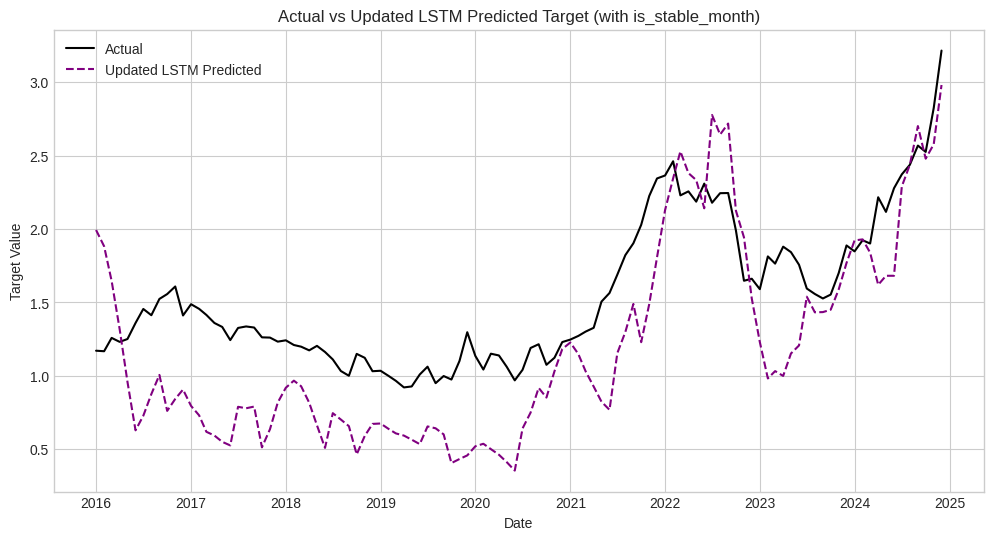

In [211]:
# Add "is_stable_month" feature before train-test split 
data['month'] = pd.to_datetime(data['date']).dt.month
data['is_stable_month'] = data['month'].apply(lambda m: 1 if m in [7, 8, 9] else 0)

# Update feature list to include the new binary flag 
feature_cols += ['is_stable_month']

X = data[feature_cols]
y = data[target_col]

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[test_idx], y.loc[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

y_pred = lstm_model.predict(X_test_lstm).flatten()

mae = mean_absolute_error(y_test_np, y_pred)
mape = np.mean(np.abs((y_test_np - y_pred) / y_test_np)) * 100
mse = mean_squared_error(y_test_np, y_pred)

print(f"Updated LSTM (with is_stable_month) Test MAE: {mae:.4f}")
print(f"Updated LSTM Test MAPE: {mape:.2f}%")
print(f"Updated LSTM Test MSE: {mse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(data.loc[test_idx, 'date'], y_test_np, label='Actual', color='black')
plt.plot(data.loc[test_idx, 'date'], y_pred, label='Updated LSTM Predicted', color='purple', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.title('Actual vs Updated LSTM Predicted Target (with is_stable_month)')
plt.legend()
plt.grid(True)
plt.show()

In [212]:
def train_test_split_lstm(data, num_lags_target=3, num_lags_oni=3, split_date='2015-12-31'):
    data = data.rename(columns={'value': 'target', 'oni': 'oni_value'})
    data = add_lags(data, 'target', num_lags_target)
    data = add_lags(data, 'oni_value', num_lags_oni)
    data = data.dropna().reset_index(drop=True)

    feature_cols = [f'target_lag_{i}' for i in range(1, num_lags_target + 1)] + \
                   [f'oni_value_lag_{i}' for i in range(1, num_lags_oni + 1)] + ['oni_value']
    target_col = 'target'

    X = data[feature_cols]
    y = data[target_col]

    split_date = pd.Timestamp(split_date)
    train_idx = data['date'] <= split_date
    test_idx = data['date'] > split_date

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()

    lstm_model = Sequential()
    lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm_model.fit(
        X_train_lstm, y_train_np,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = lstm_model.predict(X_test_lstm).flatten()

    mae = mean_absolute_error(y_test_np, y_pred)
    mape = np.mean(np.abs((y_test_np - y_pred) / y_test_np)) * 100
    mse = mean_squared_error(y_test_np, y_pred)

    print(f"LSTM Test MAE: {mae:.4f}")
    print(f"LSTM Test MAPE: {mape:.2f}%")
    print(f"LSTM Test MSE: {mse:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(data.loc[test_idx, 'date'], y_test_np, label='Actual', color='black')
    plt.plot(data.loc[test_idx, 'date'], y_pred, label='LSTM Predicted', color='green', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.title('Actual vs LSTM Predicted Target')
    plt.legend()
    plt.grid(True)
    plt.show()

In [213]:
def train_test_split_lstm_with_flag(data, num_lags_target=3, num_lags_oni=3, split_date='2015-12-31'):
    data = data.rename(columns={'value': 'target', 'oni': 'oni_value'})
    data = add_lags(data, 'target', num_lags_target)
    data = add_lags(data, 'oni_value', num_lags_oni)
    data = data.dropna().reset_index(drop=True)

    data['month'] = pd.to_datetime(data['date']).dt.month
    data['is_stable_month'] = data['month'].apply(lambda m: 1 if m in [7, 8, 9] else 0)

    feature_cols = [f'target_lag_{i}' for i in range(1, num_lags_target + 1)] + \
                   [f'oni_value_lag_{i}' for i in range(1, num_lags_oni + 1)] + \
                   ['oni_value', 'is_stable_month']
    target_col = 'target'

    X = data[feature_cols]
    y = data[target_col]

    split_date = pd.Timestamp(split_date)
    train_idx = data['date'] <= split_date
    test_idx = data['date'] > split_date

    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_test, y_test = X.loc[test_idx], y.loc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()

    lstm_model = Sequential()
    lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = lstm_model.fit(
        X_train_lstm, y_train_np,
        validation_split=0.2,
        epochs=100,
        batch_size=16,
        callbacks=[early_stop],
        verbose=1
    )

    y_pred = lstm_model.predict(X_test_lstm).flatten()

    mae = mean_absolute_error(y_test_np, y_pred)
    mape = np.mean(np.abs((y_test_np - y_pred) / y_test_np)) * 100
    mse = mean_squared_error(y_test_np, y_pred)

    print(f"Updated LSTM (with is_stable_month) Test MAE: {mae:.4f}")
    print(f"Updated LSTM Test MAPE: {mape:.2f}%")
    print(f"Updated LSTM Test MSE: {mse:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(data.loc[test_idx, 'date'], y_test_np, label='Actual', color='black')
    plt.plot(data.loc[test_idx, 'date'], y_pred, label='Updated LSTM Predicted', color='purple', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Target Value')
    plt.title('Actual vs Updated LSTM Predicted Target (with is_stable_month)')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/100


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 1.1134 - val_loss: 2.1699
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8962 - val_loss: 1.7023
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6884 - val_loss: 1.2333
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4883 - val_loss: 0.8275
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3527 - val_loss: 0.5679
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2817 - val_loss: 0.4266
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2543 - val_loss: 0.3838
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2423 - val_loss: 0.3975
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2309 - val_loss: 0.4724
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2282 - val_loss: 0.5599
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1870 - val_loss: 0.6515
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1838 - val

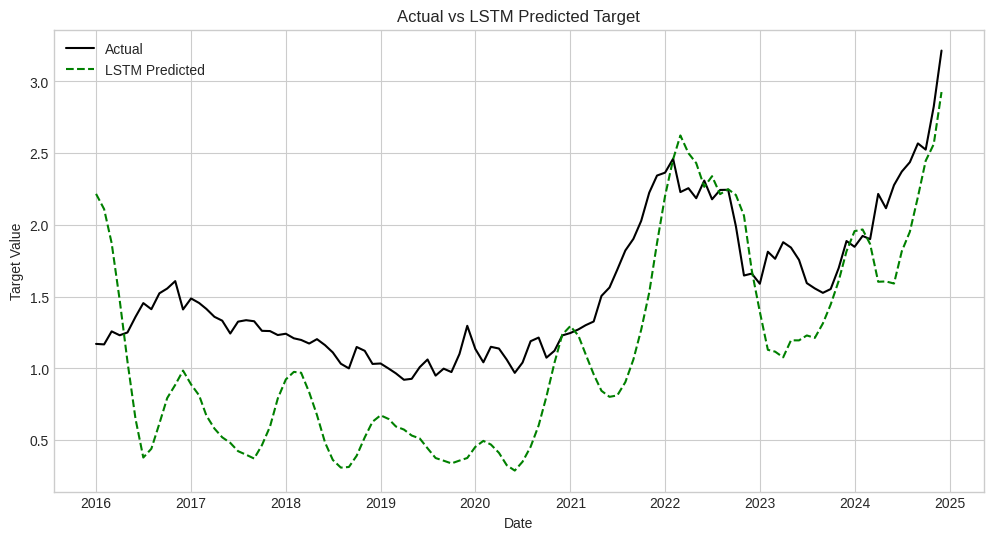

Epoch 1/100


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 1.1918 - val_loss: 2.5104
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9693 - val_loss: 1.9633
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7378 - val_loss: 1.4492
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5381 - val_loss: 1.0101
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4129 - val_loss: 0.6656
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2681 - val_loss: 0.4967
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2802 - val_loss: 0.4020
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2133 - val_loss: 0.3879
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1986 - val_loss: 0.4225
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1827 - val_loss: 0.5519
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1571 - val_loss: 0.6248
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1486 - val

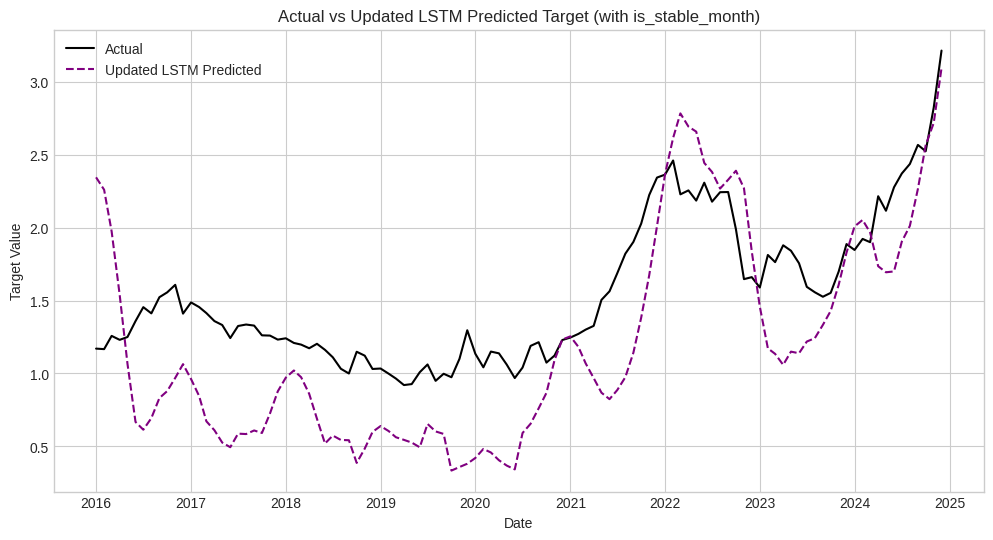

In [214]:
# Run basic LSTM
train_test_split_lstm(data)

# Run updated LSTM with `is_stable_month`
train_test_split_lstm_with_flag(data)

#### Model Comparison and Insights

| Model                         | MAE    | MAPE    | MSE    |
|------------------------------|--------|---------|--------|
| Original LSTM                | 0.5020 | 37.08%  | 0.3334 |
| Updated LSTM (`is_stable_month`) | **0.4669** | **34.29%** | **0.2845** |


The **updated LSTM model**, which includes the `is_stable_month` feature (a binary indicator for months July–September), outperformed the original LSTM across all evaluation metrics.

Incorporating domain-specific temporal features, through feature engineering insights, like `is_stable_month` helped the model recognise **seasonal stability** patterns, particularly for months where volatility tends to be lower. This kind of temporal context can be especially valuable for time series models like LSTMs, which are sensitive to time-dependent variations.


## Traditional Models

### SARIMAX

No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.


                               SARIMAX Results                                
Dep. Variable:         log_diff_value   No. Observations:                  311
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 330.518
Date:                Tue, 03 Jun 2025   AIC                           -641.036
Time:                        18:30:39   BIC                           -603.703
Sample:                    12-01-1987   HQIC                          -626.110
                         - 10-01-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -8.083e-06   6.83e-06     -1.184      0.236   -2.15e-05    5.29e-06
oni_lag5      -0.0062      0.010     -0.630      0.529      -0.026       0.013
oni_lag9       0.0090      0.008      1.057      0.2

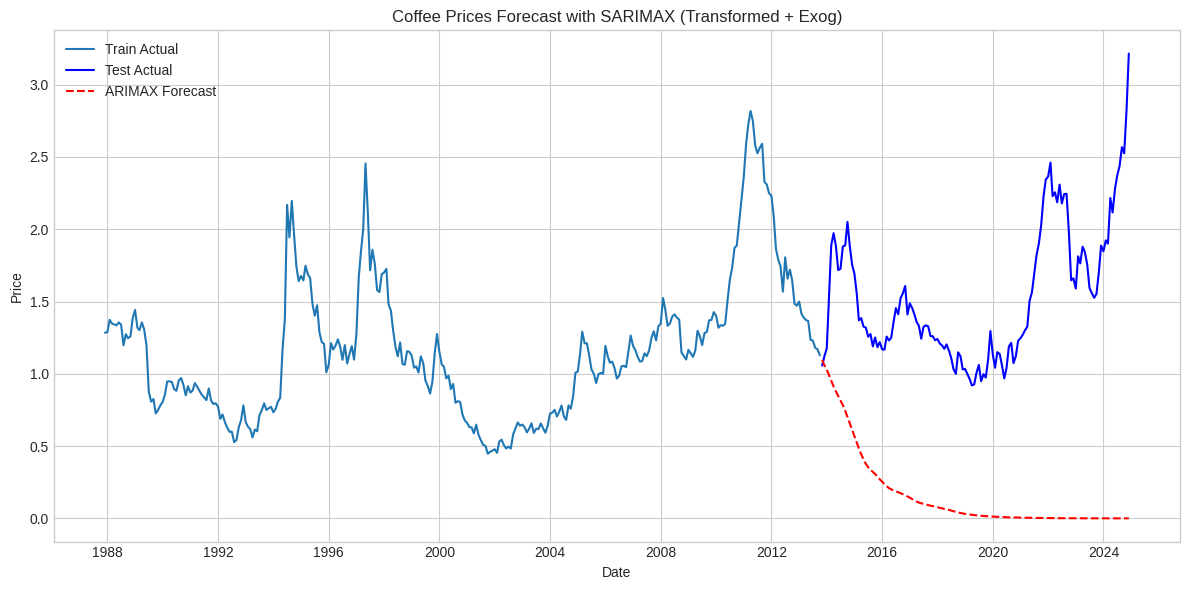

In [215]:
exog_vars = ['oni_lag5', 'oni_lag9', 'oni_lag22', 'open_lag3', 'close_lag6', 'high_lag1']

df_clean = df.dropna(subset=['value'] + exog_vars)

df_clean = df_clean.reset_index(drop=True)
df_clean.index = pd.to_datetime(df_clean['date'])

df_clean['log_value'] = np.log(df_clean['value'])
df_clean['log_diff_value'] = df_clean['log_value'].diff()
df_clean = df_clean.dropna(subset=['log_diff_value'])  # drop initial NA after differencing

train_size = int(len(df_clean) * 0.7)
train = df_clean.iloc[:train_size]
test = df_clean.iloc[train_size:]

# Fit SARIMAX model on log-differenced data 
model = SARIMAX(
    train['log_diff_value'],
    order=(1, 0, 1),  # since we differenced manually
    exog=train[exog_vars],
    trend='t',
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

forecast_diff = model_fit.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[exog_vars]
)

# Reconstruct log values from differenced forecasts 
last_log_train_value = train['log_value'].iloc[-1]
forecast_log = forecast_diff.cumsum() + last_log_train_value

# Convert back to original scale 
forecast = np.exp(forecast_log)

y_true = test['value']
y_pred = forecast

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n=== ARIMAX (log-diff + exog) Performance ===")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Train Actual')
plt.plot(test.index, y_true, label='Test Actual', color='blue')
plt.plot(test.index, y_pred, label='ARIMAX Forecast', color='red', linestyle='--')
plt.title('Coffee Prices Forecast with SARIMAX (Transformed + Exog)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

No frequency information was provided, so inferred frequency MS will be used.
No frequency information was provided, so inferred frequency MS will be used.
Maximum Likelihood optimization failed to converge. Check mle_retvals


                                     SARIMAX Results                                      
Dep. Variable:                     log_diff_value   No. Observations:                  310
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 261.309
Date:                            Tue, 03 Jun 2025   AIC                           -498.618
Time:                                    18:30:52   BIC                           -454.831
Sample:                                01-01-1988   HQIC                          -481.063
                                     - 10-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -3.366e-06   7.02e-06     -0.479      0.632   -1.71e-05    1.04e-05
oni_lag5      -0.0132      0.013   

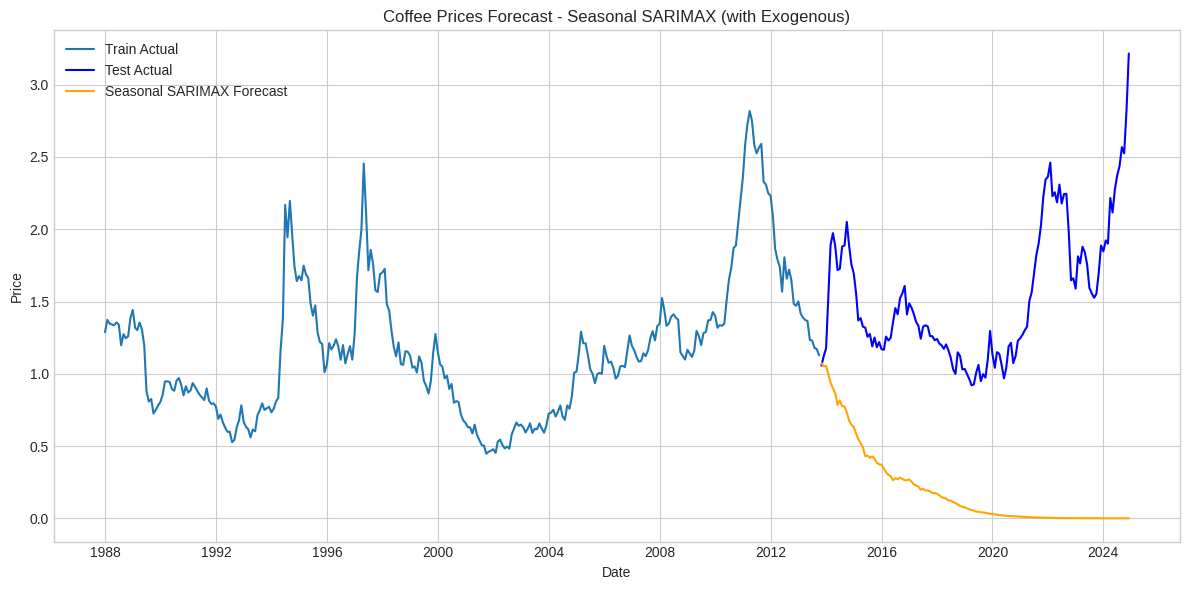

In [216]:
exog_vars = ['oni_lag5', 'oni_lag9', 'oni_lag22', 'open_lag3', 'close_lag6', 'high_lag1']

df_clean = df.dropna(subset=['value'] + exog_vars).copy()
df_clean.index = pd.to_datetime(df_clean['date'])

# Log transform + differencing  
df_clean['log_value'] = np.log(df_clean['value'])
df_clean['log_diff_value'] = df_clean['log_value'].diff()
df_clean = df_clean.dropna()

# Train-test split (70% train) 
train_size = int(len(df_clean) * 0.7)
train = df_clean.iloc[:train_size]
test = df_clean.iloc[train_size:]

# Define SARIMAX with seasonal components 
model = SARIMAX(
    train['log_diff_value'],
    exog=train[exog_vars],
    order=(1, 0, 1),                # p, d, q
    seasonal_order=(1, 1, 1, 12),   # P, D, Q, s (monthly seasonality)
    trend='t',
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)
print(model_fit.summary())

forecast = model_fit.predict(
    start=test.index[0],
    end=test.index[-1],
    exog=test[exog_vars]
)

last_log_value = train['log_value'].iloc[-1]
log_forecast = forecast.cumsum() + last_log_value
price_forecast = np.exp(log_forecast)

y_true = test['value']
y_pred = price_forecast

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n=== Seasonal SARIMAX (log-diff + exog + seasonality) Performance ===")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Train Actual')
plt.plot(test.index, y_true, label='Test Actual', color='blue')
plt.plot(test.index, y_pred, label='Seasonal SARIMAX Forecast', color='orange')
plt.title('Coffee Prices Forecast - Seasonal SARIMAX (with Exogenous)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Model Comparison and Insights


| Model                                           | RMSE   | MAE    | MAPE    |
|------------------------------------------------|--------|--------|---------|
| **SARIMA (seasonality only)**                    | 1.5533 | 1.4696 | 95.54%  | 
| **Seasonal SARIMAX (log-diff + exog + seasonality)** | **1.4631** | **1.3571** | **87.18%** | 




- **Seasonal SARIMAX clearly outperforms SARIMA** by leveraging both seasonal patterns and external predictors (exogenous variables like ONI and price lags).
- This combination reduces error significantly, with about **6–8% improvement in MAPE**, showing that including relevant external features enhances forecasting.
- SARIMA alone models seasonality but misses out on important drivers captured by exogenous variables, resulting in less accurate forecasts.

#### VAR with differencing

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
invalid value encountered in sqrt
invalid value encountered in less_equal


Lag order selection criteria (differenced data):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.03      -13.98   8.101e-07      -14.01
1       -17.14      -16.89   3.591e-08      -17.04
2       -17.49      -17.04   2.527e-08      -17.31
3       -17.82      -17.17   1.821e-08      -17.56
4       -79.91      -79.06   1.975e-35      -79.57
5       -80.43      -79.38   1.180e-35      -80.01
6       -81.30      -80.05   4.921e-36      -80.80
7       -82.72      -81.27   1.195e-36      -82.14
8       -81.44      -79.79   4.313e-36      -80.78
9       -83.12      -81.28   7.977e-37      -82.39
10      -82.43      -80.39   1.598e-36      -81.61
11      -83.92      -81.68   3.610e-37      -83.02
12      -84.29      -81.84   2.511e-37      -83.31
13     -147.7*     -145.1*  7.319e-65*     -146.6*
14      -146.4      -143.5   2.710e-64      -145.2
15      -146.9      -143.8   1.65

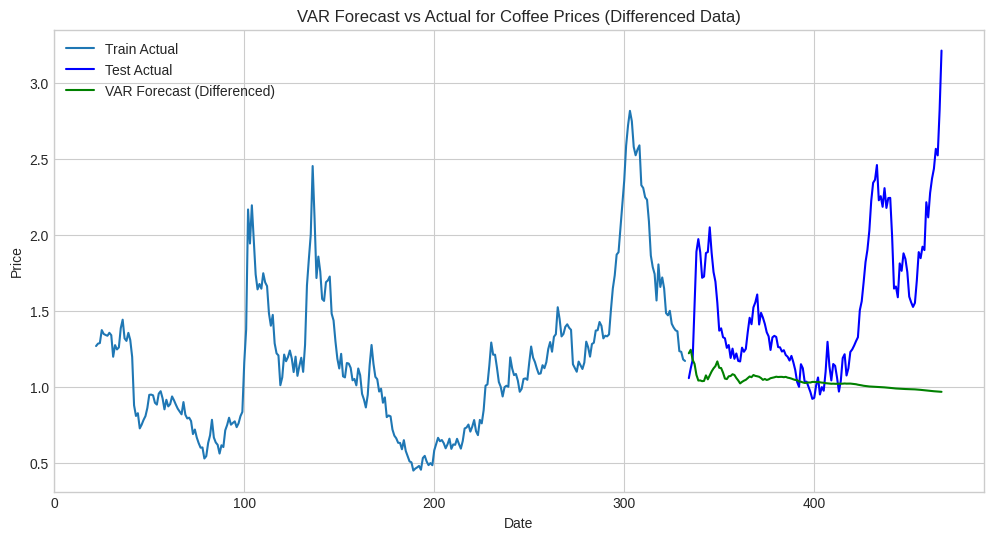

In [217]:
df_var = df[['value', 'oni_lag5', 'oni_lag9', 'oni_lag22']].dropna()

# Differencing to induce stationarity
df_diff = df_var.diff().dropna()

# Train-test split on differenced data
train_size = int(len(df_diff) * 0.7)
train_diff = df_diff.iloc[:train_size]
test_diff = df_diff.iloc[train_size:]

# Fit VAR model on differenced data
model = VAR(train_diff)
lag_order_results = model.select_order(maxlags=15)
print("Lag order selection criteria (differenced data):")
print(lag_order_results.summary())

best_lag = lag_order_results.selected_orders['bic']  # you can switch to 'aic' or 'hqic'
print(f"Selected best lag order = {best_lag}")

model_fit = model.fit(best_lag)
print(model_fit.summary())

# Forecast differenced values
forecast_diff = model_fit.forecast(train_diff.values[-best_lag:], steps=len(test_diff))
forecast_diff_df = pd.DataFrame(forecast_diff, index=test_diff.index, columns=df_diff.columns)

# Invert differencing to get forecast in original scale
last_train = df_var.iloc[train_size - 1]
forecast_inverted = forecast_diff_df.cumsum() + last_train.values
forecast_inverted_df = pd.DataFrame(forecast_inverted, columns=df_var.columns, index=test_diff.index)

true_values = df_var['value'].iloc[train_size + 1 : train_size + 1 + len(forecast_inverted_df)]

rmse = np.sqrt(mean_squared_error(true_values, forecast_inverted_df['value']))
mae = mean_absolute_error(true_values, forecast_inverted_df['value'])
mape = np.mean(np.abs((true_values - forecast_inverted_df['value']) / true_values)) * 100

print(f"VAR on Differenced Data Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6))
plt.plot(df_var.index[:train_size], df_var['value'][:train_size], label='Train Actual')
plt.plot(true_values.index, true_values, label='Test Actual', color='blue')
plt.plot(forecast_inverted_df.index, forecast_inverted_df['value'], label='VAR Forecast (Differenced)', color='green')
plt.title('VAR Forecast vs Actual for Coffee Prices (Differenced Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Model Insights

| Metric | Value   |
|--------|---------|
| RMSE   | 0.7973  |
| MAE    | 0.6355  |
| MAPE   | 36.11%  |

**Key Insights:**

- The VAR model on differenced data achieves a **moderate forecasting accuracy**.
- The RMSE and MAE indicate reasonable error magnitudes given the data scale.
- The MAPE of 36.11% suggests the model has some difficulty with percentage-based errors but still captures general trends.
- Differencing effectively induces stationarity, helping improve model stability and performance.


## Stacked Ensemble Model

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
✅ Ensemble MAE: 0.1119
✅ Ensemble MSE: 0.0224
✅ Ensemble MAPE: 6.83%


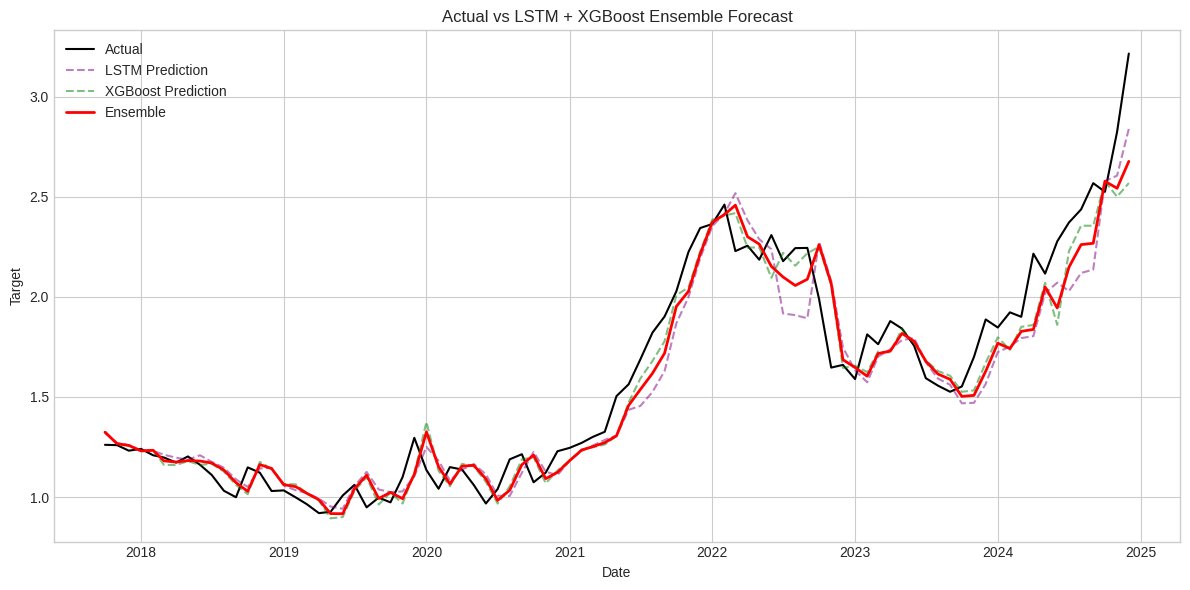

In [56]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

data['month'] = pd.to_datetime(data['date']).dt.month
data['is_stable_month'] = data['month'].apply(lambda m: 1 if m in [7, 8, 9] else 0)

feature_cols += ['is_stable_month']
target_col = 'target'  

X = data[feature_cols].copy()
y = data[target_col].copy()

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]
X_test = X.loc[test_idx]
y_test = y.loc[test_idx]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_model.fit(
    X_train_lstm, y_train_np,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)

# LSTM Predictions 
y_pred = lstm_model.predict(X_test_lstm).flatten()
test_dates = data.loc[test_idx, 'date']
lstm_preds = pd.Series(y_pred, index=test_dates)
y_true = pd.Series(y_test_np, index=test_dates)

# Rolling XGBoost Forecast 
initial_train_size = int(len(X) * 0.8)
window_predictions = []
window_actuals = []
rolling_dates = []

for i in range(initial_train_size, len(X)):
    X_train_window = X.iloc[:i]
    y_train_window = y.iloc[:i]
    X_test_window = X.iloc[i:i+1]
    y_test_window = y.iloc[i:i+1]

    X_train_scaled = scaler.fit_transform(X_train_window)
    X_test_scaled = scaler.transform(X_test_window)

    xgb_params = best_model.get_params()
    xgb_params['random_state'] = SEED
    xgb_model = XGBRegressor(**xgb_params)

    xgb_model.fit(X_train_scaled, y_train_window)

    y_pred_xgb = xgb_model.predict(X_test_scaled)
    window_predictions.append(y_pred_xgb[0])
    window_actuals.append(y_test_window.values[0])
    rolling_dates.append(data.loc[X_test_window.index, 'date'].values[0])

rolling_preds = pd.Series(window_predictions, index=pd.to_datetime(rolling_dates))

# Align and Combine 
common_index = y_true.index.intersection(rolling_preds.index)

ensemble_df = pd.DataFrame({
    'actual': y_true.loc[common_index],
    'lstm': lstm_preds.loc[common_index],
    'xgb': rolling_preds.loc[common_index]
}).dropna()

# Weighted Ensemble 
w_lstm = 0.4
w_xgb = 0.6
ensemble_df['ensemble'] = w_lstm * ensemble_df['lstm'] + w_xgb * ensemble_df['xgb']

# === 7. Evaluation ===
ensemble_mae = mean_absolute_error(ensemble_df['actual'], ensemble_df['ensemble'])
ensemble_mse = mean_squared_error(ensemble_df['actual'], ensemble_df['ensemble'])
ensemble_mape = np.mean(np.abs((ensemble_df['actual'] - ensemble_df['ensemble']) / ensemble_df['actual'])) * 100

print(f"✅ Ensemble MAE: {ensemble_mae:.4f}")
print(f"✅ Ensemble MSE: {ensemble_mse:.4f}")
print(f"✅ Ensemble MAPE: {ensemble_mape:.2f}%")

# === 8. Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(ensemble_df.index, ensemble_df['actual'], label='Actual', color='black')
plt.plot(ensemble_df.index, ensemble_df['lstm'], label='LSTM Prediction', linestyle='--', color='purple', alpha=0.5)
plt.plot(ensemble_df.index, ensemble_df['xgb'], label='XGBoost Prediction', linestyle='--', color='green', alpha=0.5)
plt.plot(ensemble_df.index, ensemble_df['ensemble'], label='Ensemble', color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Actual vs LSTM + XGBoost Ensemble Forecast')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model Performance Comparison

| Model                                         | MAE    | MAPE    | MSE     |
|----------------------------------------------|--------|---------|---------|
| Updated LSTM (is_stable_month)               | 0.3895 | 28.05%  | 0.1972  |
| Random Forest (Regularised)                   | 0.0986 | 6.45%   | 0.0197  |
| XGBoost with Rolling Forecast                 | 0.1012 | 6.24%   | 0.0211  |
| Simple + RFE selected engineered features     | 0.0978 | 6.04%   | 0.0208  |
| **LSTM + XGBoost Ensemble**                    | 0.1119 | 6.83%   | 0.0224  |

---

## Key Insights

- **Best Individual Model:**  
  The *Simple + RFE selected engineered features* model remains the top-performing standalone model with the lowest MAE (0.0978) and MAPE (6.04%), making it the most accurate and reliable for direct deployment.

- **LSTM + XGBoost Ensemble:**  
  The *Ensemble model* that combines LSTM and XGBoost predictions achieves competitive performance (MAE: 0.1119, MAPE: 6.83%). This hybrid approach captures both temporal dynamics and engineered feature interactions, offering robustness and model diversity.

- **Tree-Based Models:**  
  Both *Random Forest* and *XGBoost* demonstrate strong performance with low errors, confirming their effectiveness in capturing complex relationships in structured feature sets.

- **LSTM Alone:**  
  Despite enhancements like the `is_stable_month` feature, the LSTM model still performs worse than classical ML models, indicating limited value from deep learning in this particular use case.

- **Traditional Time Series Models:**  
  Classical methods such as *SARIMAX* and *VAR*, even after differencing and transformations to ensure stationarity, performed poorly relative to ML models. This reinforces the advantage of flexible machine learning models over rigid statistical assumptions in capturing the complexity of this dataset.

---

## Final Recommendation

- **Best Option:** Use the *Simple + RFE selected engineered features* model for its top accuracy and simplicity.
- **Alternative (Hybrid):** Consider deploying the *LSTM + XGBoost Ensemble* for situations requiring robustness across temporal patterns and feature-based variance.